# Exploration of Brighton Weather data

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
# import necessary modules
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Combining and Loading data

In [3]:
# Set the path to your CSV files
csv_path = '/Users/danodyaweerasinghe/documents/MSc/Data-Science/labs/assignment-2/weatherdata_for_students/'

# Create an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Iterate through the files
for i in range(1, 129):
    filename = f'brighton_{str(i).zfill(3)}.csv'
    file_path = os.path.join(csv_path, filename)

    # Read the CSV file
    df = pd.read_csv(file_path)
    # print(df)

    # drop the numeric column headers
    if df.columns[0].startswith('0'):
        df.columns = df.iloc[0]
        df = df.drop([0])

    # Concatenate the data to the combined DataFrame
    combined_df = pd.concat([combined_df, df] , ignore_index=True)

combined_df

# output file path
output_file_path = '/Users/danodyaweerasinghe/documents/MSc/Data-Science/labs/assignment-2/combined_data_brighton.csv'

# Save combined data to a single CSV file
combined_df.to_csv(output_file_path, index=False)

In [4]:
# load the combined data CSV file
weather_data = pd.read_csv(output_file_path)
weather_data

datetime  temp  dew  humidity  precip  precipprob  \
0       2010-01-01T00:00:00   1.9 -0.5     84.25   0.417       100.0   
1       2010-01-01T01:00:00   1.9 -0.5     83.90   0.000         0.0   
2       2010-01-01T02:00:00   1.4 -0.7     85.76   0.000         0.0   
3       2010-01-01T03:00:00   1.4 -0.7     85.69   0.000         0.0   
4       2010-01-01T04:00:00   1.3 -0.8     85.72   0.000         0.0   
...                     ...   ...  ...       ...     ...         ...   
122839  2024-01-06T07:00:00   5.1  3.5     89.07     NaN         0.0   
122840  2024-01-06T08:00:00   5.0  3.5     90.24     NaN         0.0   
122841  2024-01-06T09:00:00   4.9  3.9     92.89     NaN         0.0   
122842  2024-01-06T10:00:00   5.9  4.8     92.47     NaN         0.0   
122843  2024-01-06T11:00:00   6.8  4.8     86.98     NaN         0.0   

       preciptype  snow  snowdepth  windspeed  winddir  sealevelpressure  \
0       rain,snow   0.0        0.0       19.4     11.0             999.9   
1             NaN   0.0        0.0       21.8     19.0             999.8   
2             NaN   0.0        0.0       17.7     10.0            1000.0   
3             NaN   0.0        0.0       18.0     11.0            1000.2   
4             NaN   0.0        0.0       17.4     10.0            1000.5   
...           ...   ...        ...        ...      ...               ...   
122839        NaN   NaN        NaN        9.6    327.0            1013.2   
122840        NaN   NaN        NaN        8.9    320.0            1014.0   
122841        NaN   NaN        NaN        9.6    321.0            1015.0   
122842        NaN   NaN        NaN        7.8    340.0            1016.0   
122843        NaN   NaN        NaN       16.0    349.0            1016.0   

        cloudcover  solarradiation  solarenergy  uvindex  
0             62.2             0.0          0.0      0.0  
1             22.4             0.0          0.0      0.0  
2             38.0             0.0          0.0      0.0  
3             66.7             0.0          0.0      0.0  
4             62.8             0.0          0.0      0.0  
...            ...             ...          ...      ...  
122839        65.1             0.0          0.0      0.0  
122840        89.9             0.0          0.0      0.0  
122841        85.5            23.0          0.1      0.0  
122842        51.7            72.0          0.3      1.0  
122843        29.5           178.0          0.6      2.0  

[122844 rows x 16 columns]

Hourly measurements of weather data is loaded

## Split the data

In [5]:
# Convert 'datetime' column to datetime type if it's not already in datetime format
weather_data_to_process = weather_data.copy()
weather_data_to_process['datetime'] = pd.to_datetime(weather_data_to_process['datetime'])

In [6]:
# make the datetime column the index of the X_train_weather dataframe for easier slicing
weather_data_to_process.set_index('datetime', inplace=True)
# weather_data_to_process.head()

In [7]:
# Split training, validation and test sets to avoid overfitting and data leakage
X_train = weather_data_to_process[:'2021'] # all data until 2021 (included) for training
X_validation = weather_data_to_process.loc['2022'] # all 2022 data for validation
X_test = weather_data_to_process.loc['2023':] # all 2023 and 2024 data for testing

X_validation.to_csv('brighton_validation.csv')
X_test.to_csv('brighton_test.csv')


In [8]:
# copy train set to avoid overriding the initial data
X_train_weather = X_train.copy()
X_train_weather

temp   dew  humidity  precip  precipprob preciptype  \
datetime                                                                   
2010-01-01 00:00:00   1.9  -0.5     84.25   0.417       100.0  rain,snow   
2010-01-01 01:00:00   1.9  -0.5     83.90   0.000         0.0        NaN   
2010-01-01 02:00:00   1.4  -0.7     85.76   0.000         0.0        NaN   
2010-01-01 03:00:00   1.4  -0.7     85.69   0.000         0.0        NaN   
2010-01-01 04:00:00   1.3  -0.8     85.72   0.000         0.0        NaN   
...                   ...   ...       ...     ...         ...        ...   
2021-12-31 19:00:00  11.9  11.5     97.73   0.000         0.0        NaN   
2021-12-31 20:00:00  12.0  11.6     97.65   0.000         0.0        NaN   
2021-12-31 21:00:00  11.7  11.4     97.75   0.000         0.0        NaN   
2021-12-31 22:00:00  11.7  11.4     97.75   0.000         0.0        NaN   
2021-12-31 23:00:00  11.7  11.2     96.89   0.000         0.0        NaN   

                     snow  snowdepth  windspeed  winddir  sealevelpressure  \
datetime                                                                     
2010-01-01 00:00:00   0.0        0.0       19.4     11.0             999.9   
2010-01-01 01:00:00   0.0        0.0       21.8     19.0             999.8   
2010-01-01 02:00:00   0.0        0.0       17.7     10.0            1000.0   
2010-01-01 03:00:00   0.0        0.0       18.0     11.0            1000.2   
2010-01-01 04:00:00   0.0        0.0       17.4     10.0            1000.5   
...                   ...        ...        ...      ...               ...   
2021-12-31 19:00:00   0.0        0.0       15.8    219.0            1021.9   
2021-12-31 20:00:00   0.0        0.0       14.1    204.0            1022.1   
2021-12-31 21:00:00   0.0        0.0        9.4    203.0            1022.4   
2021-12-31 22:00:00   0.0        0.0       10.9    210.0            1022.1   
2021-12-31 23:00:00   0.0        0.0       12.1    202.0            1022.0   

                     cloudcover  solarradiation  solarenergy  uvindex  
datetime                                                               
2010-01-01 00:00:00        62.2             0.0          0.0      0.0  
2010-01-01 01:00:00        22.4             0.0          0.0      0.0  
2010-01-01 02:00:00        38.0             0.0          0.0      0.0  
2010-01-01 03:00:00        66.7             0.0          0.0      0.0  
2010-01-01 04:00:00        62.8             0.0          0.0      0.0  
...                         ...             ...          ...      ...  
2021-12-31 19:00:00        93.6             0.0          0.0      0.0  
2021-12-31 20:00:00        94.4             0.0          0.0      0.0  
2021-12-31 21:00:00        90.3             0.0          0.0      0.0  
2021-12-31 22:00:00        95.8             0.0          0.0      0.0  
2021-12-31 23:00:00        92.0             0.0          0.0      0.0  

[105192 rows x 15 columns]

## Plot the loaded data

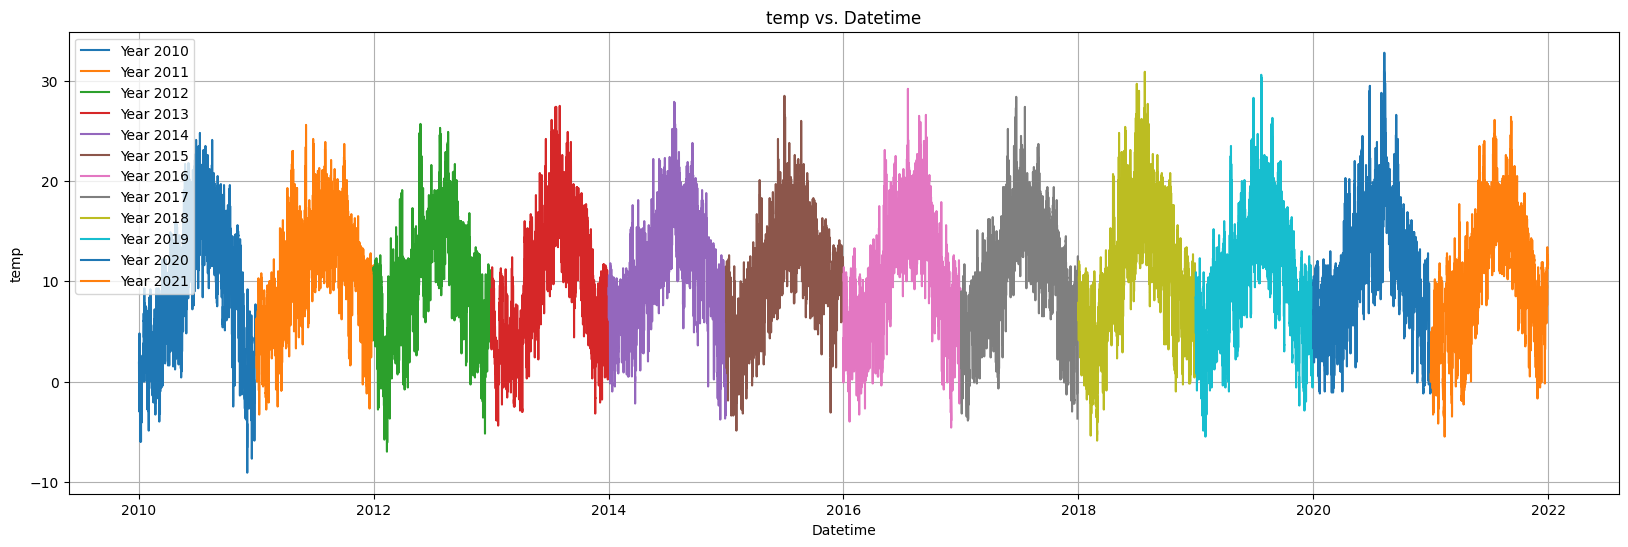

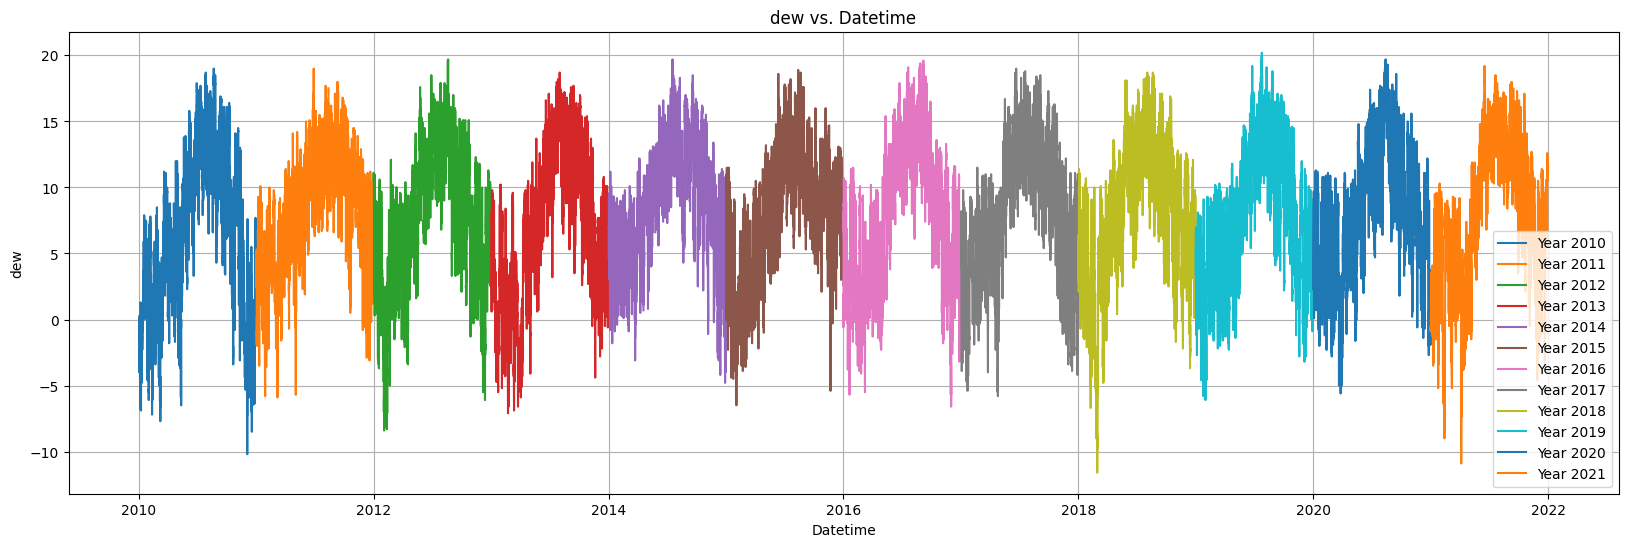

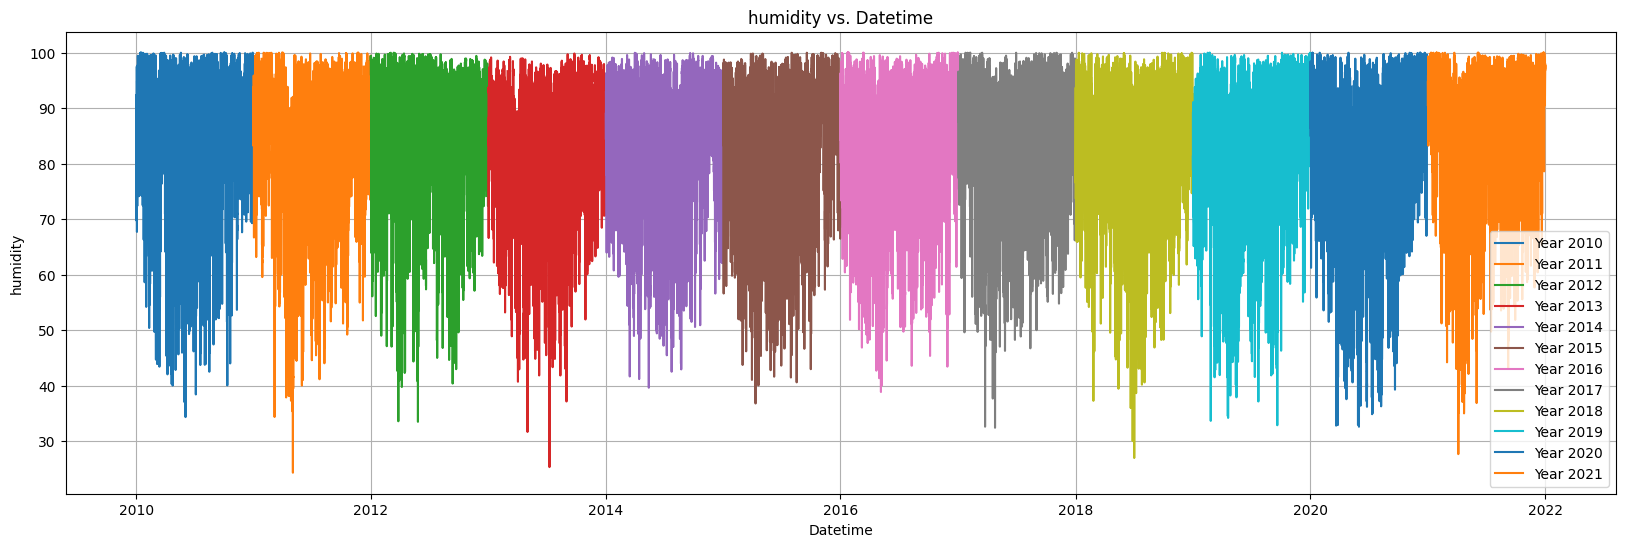

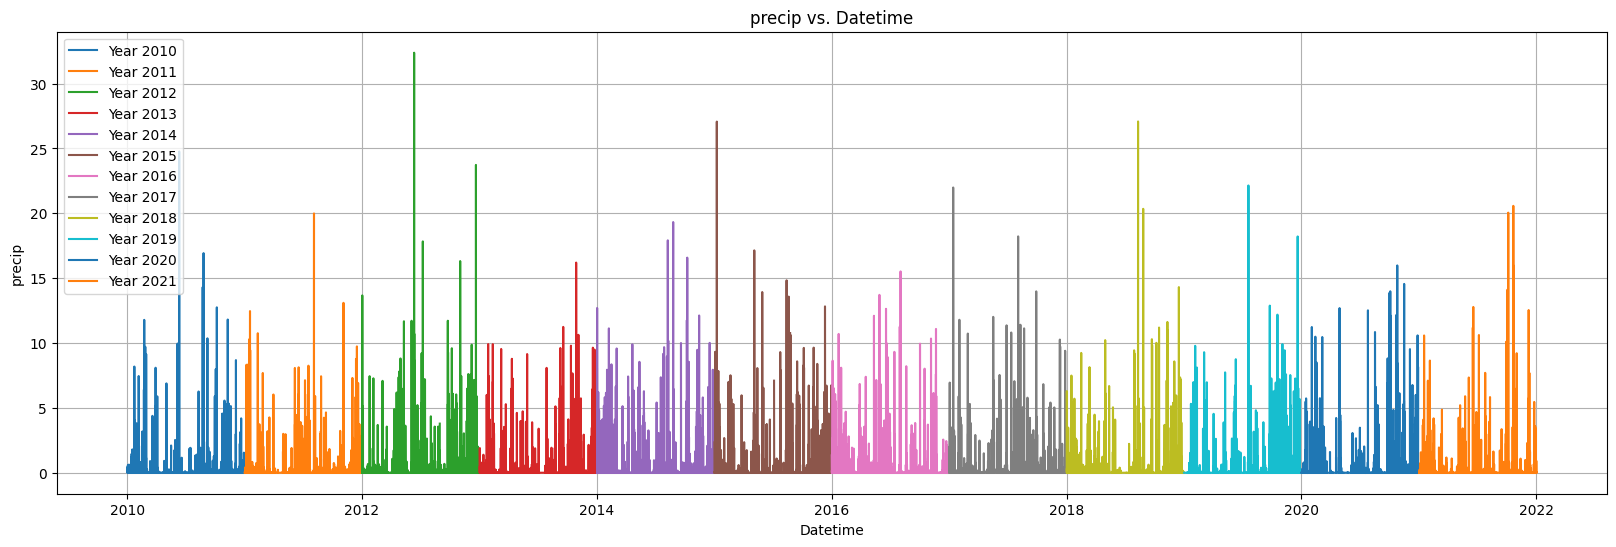

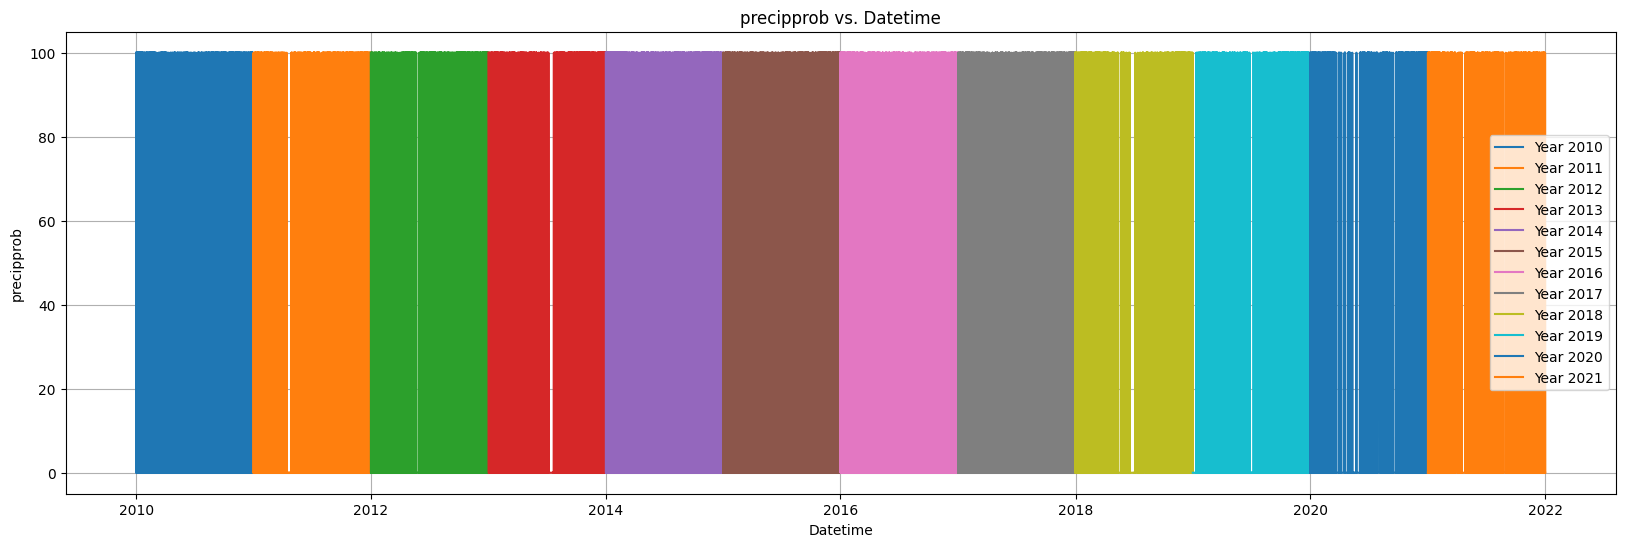

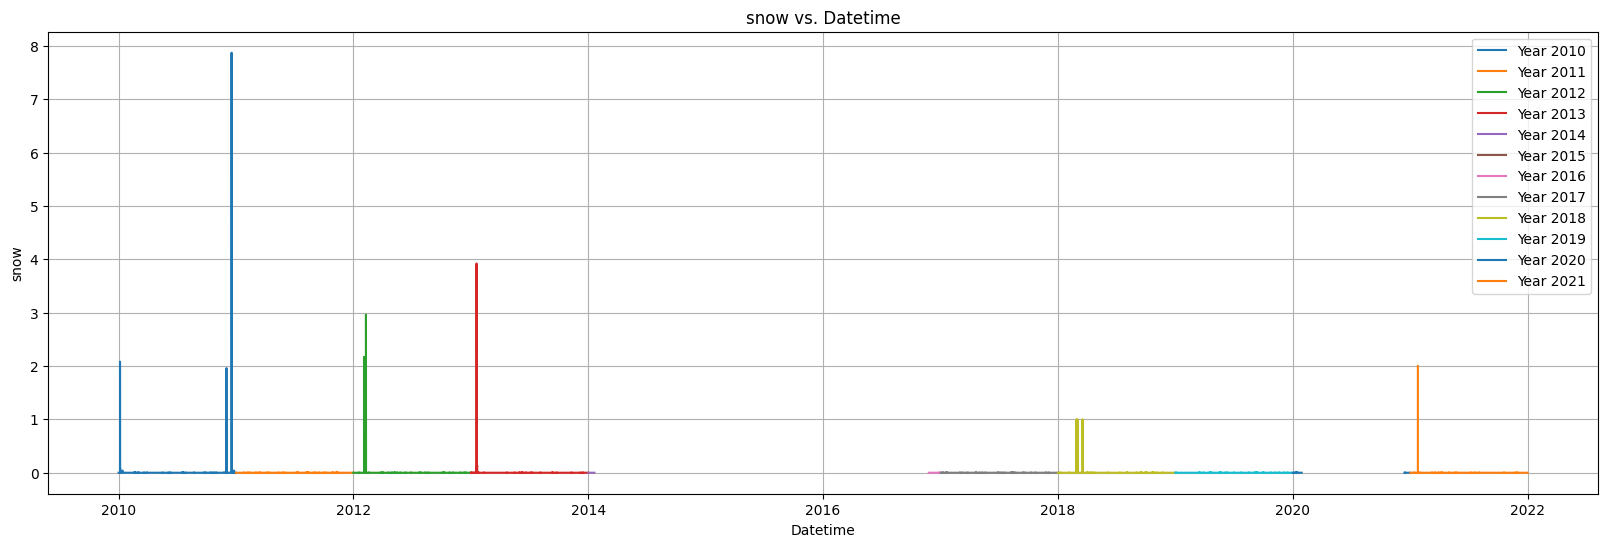

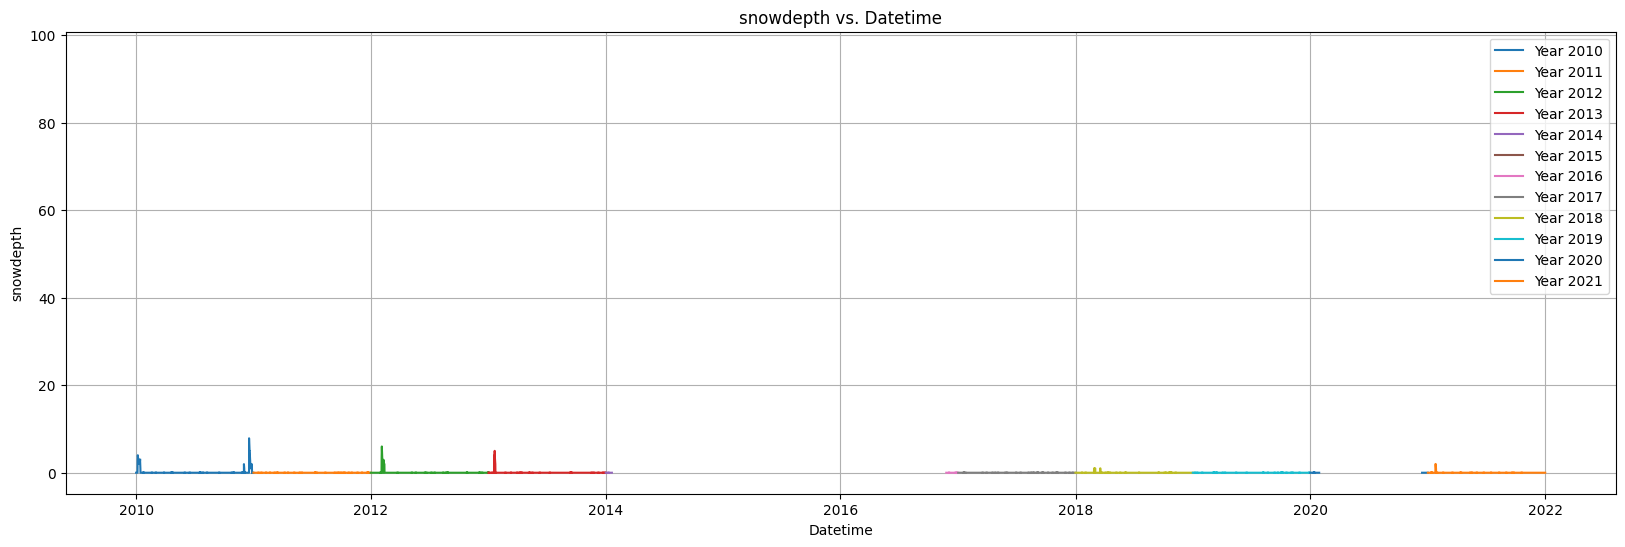

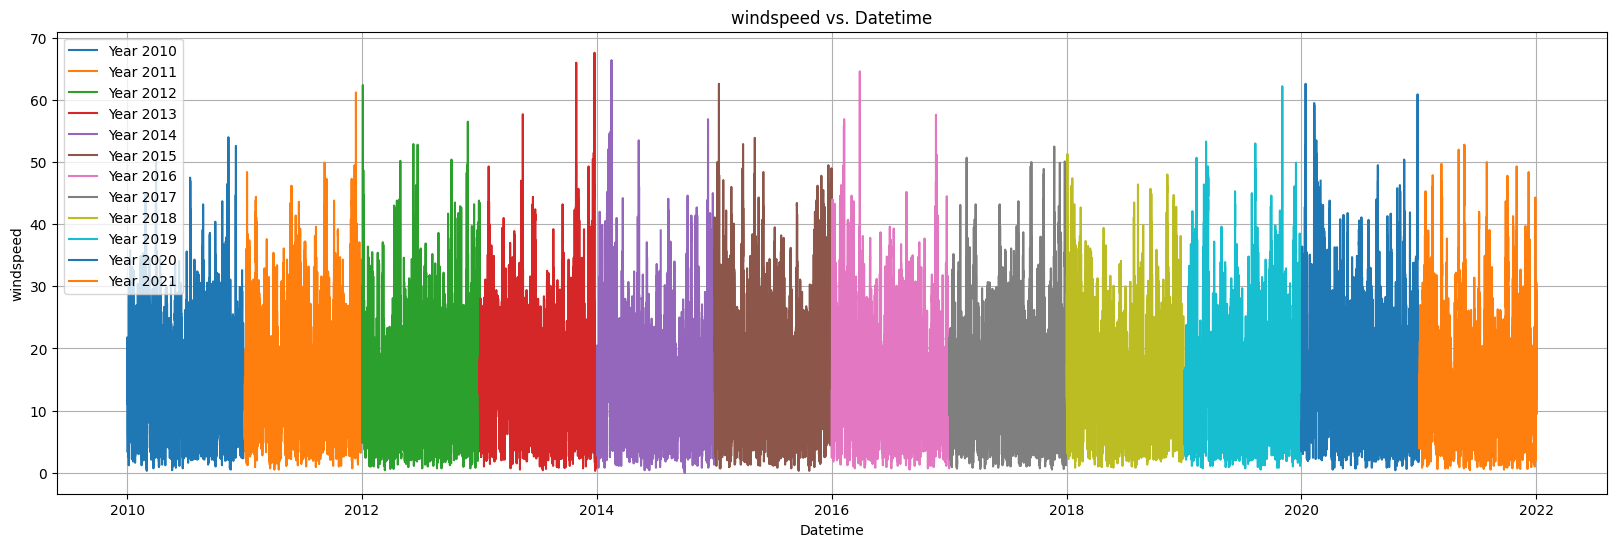

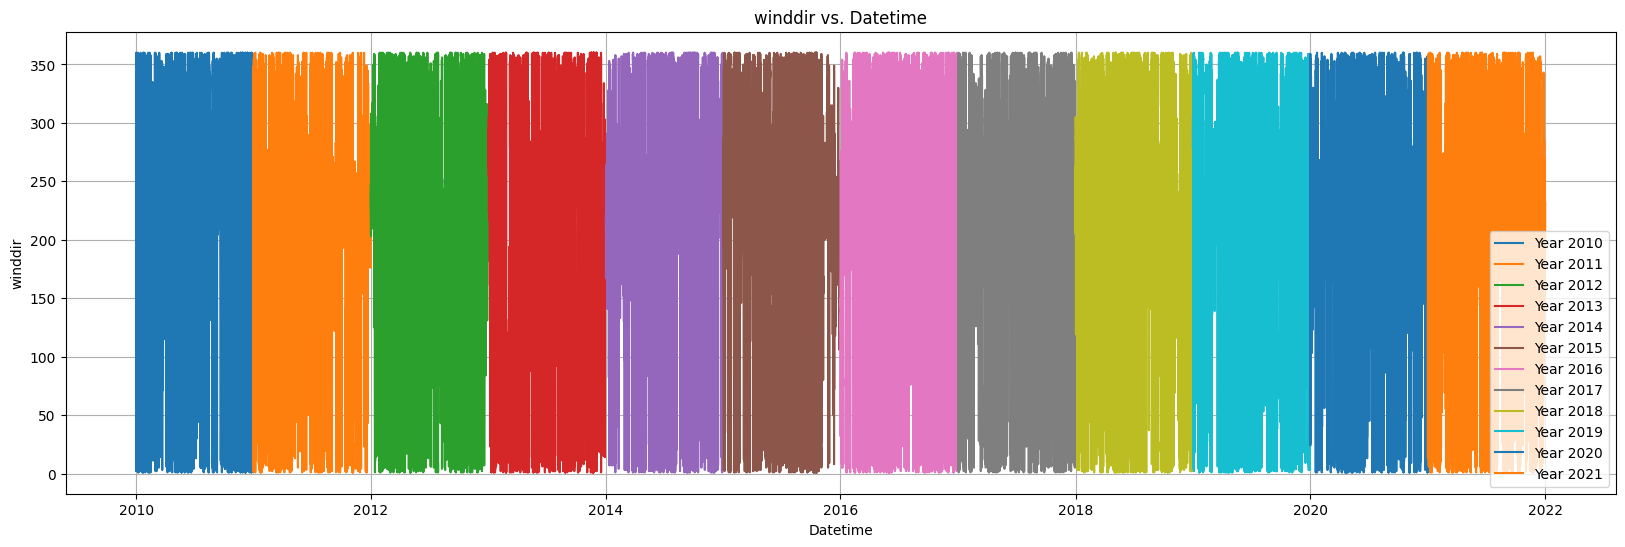

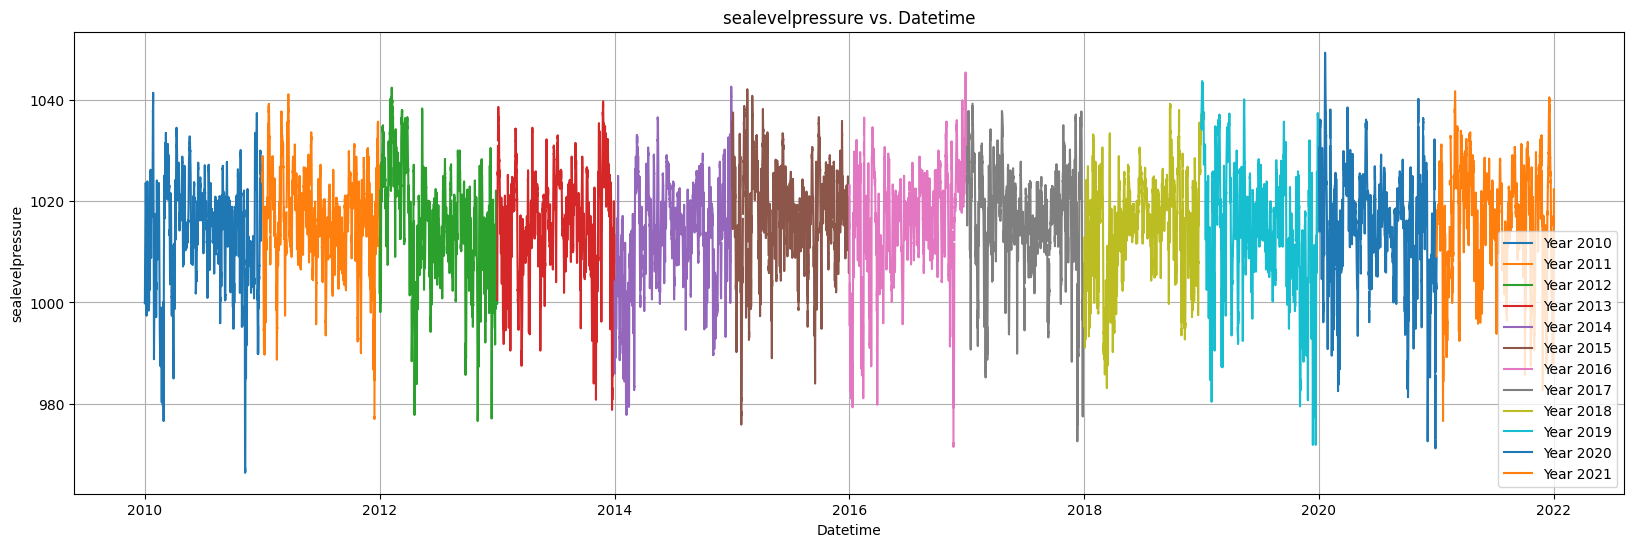

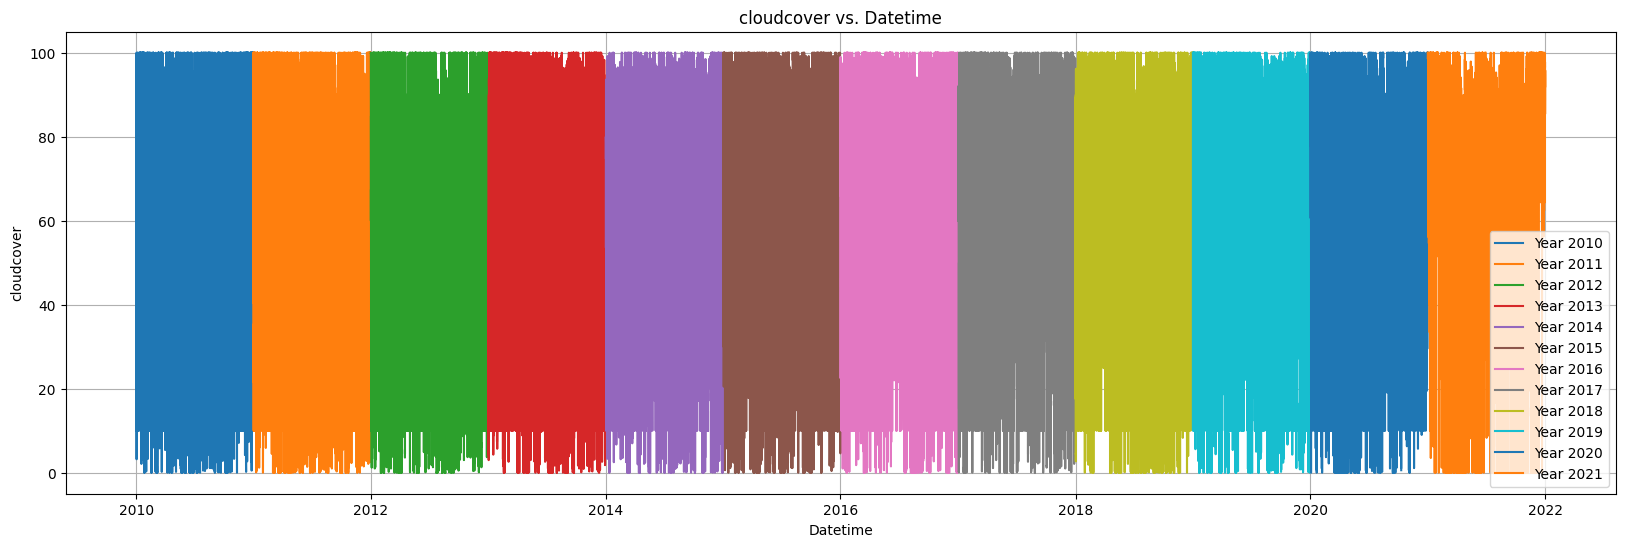

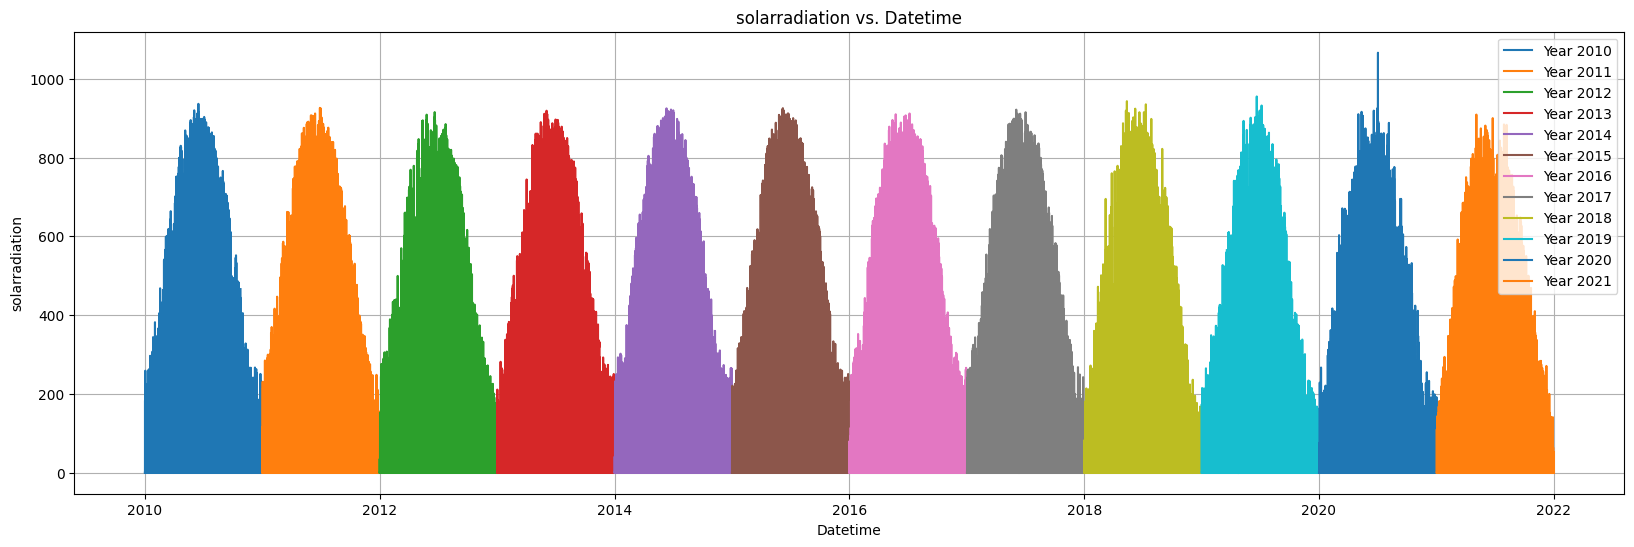

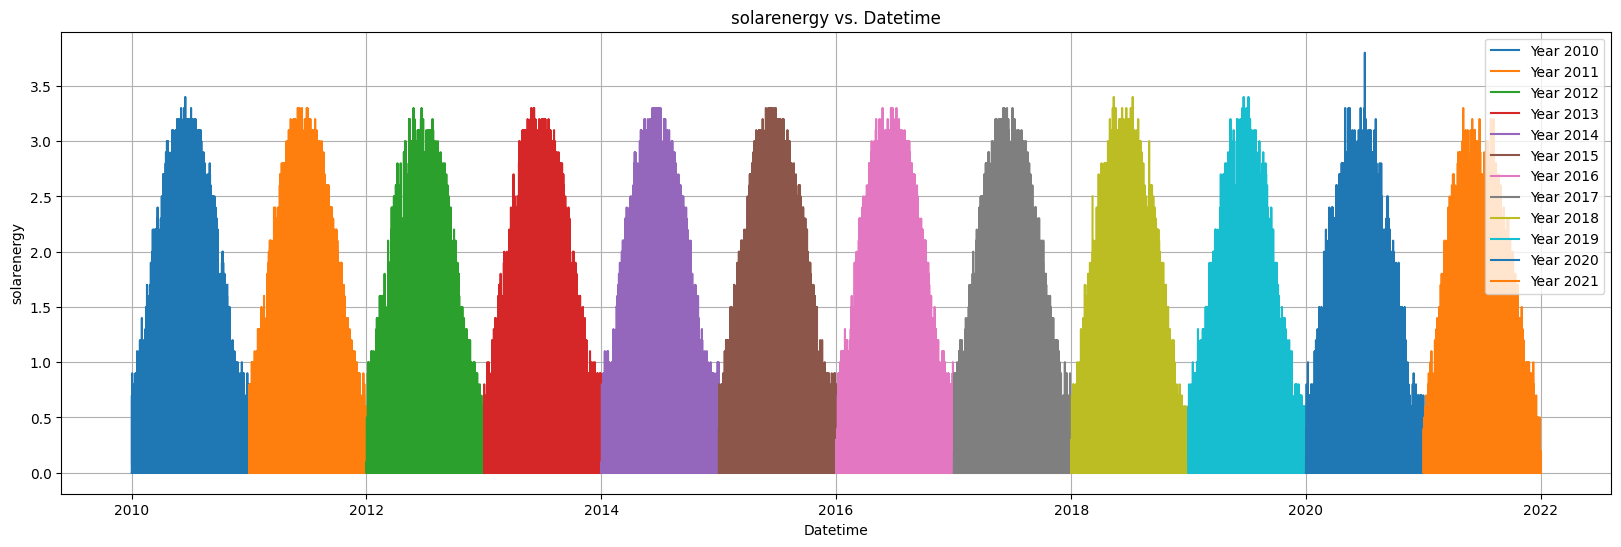

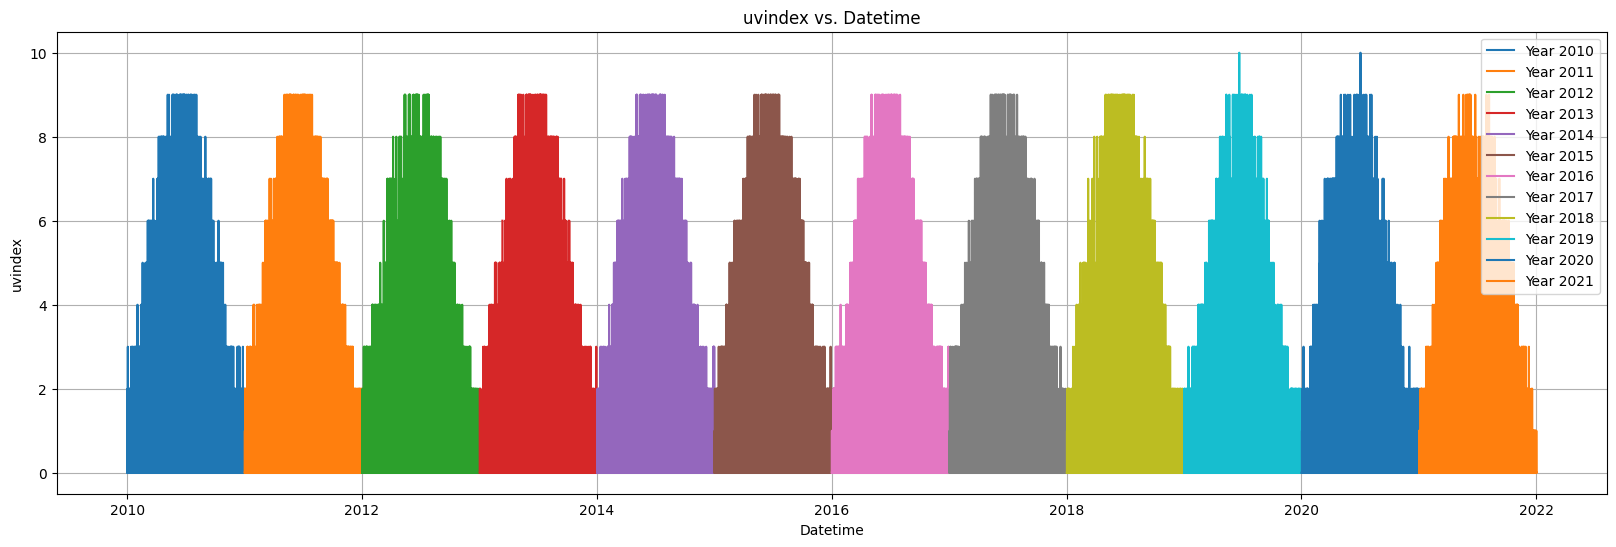

In [9]:
# function to plot data for given columns
def plot_data(X_train_weather):
    # Group the DataFrame by year
    grouped_by_year = X_train_weather.groupby(X_train_weather.index.year)
    
    # Iterate over each column and create separate plots for each column with all years
    for column in X_train_weather.columns:
        #if column != 'preciptype':
        if column != 'preciptype':  # Skip the datetime column itself
            plt.figure(figsize=(20, 6))
            for year, group in grouped_by_year:
                plt.plot(group.index, group[column], label=f'Year {year}')
    
            # Set the title, x-axis label, y-axis label, and legend
            plt.title(f'{column} vs. Datetime')
            plt.xlabel('Datetime')
            plt.ylabel(column)
            plt.legend()
            plt.grid(True)
            plt.show()

plot_data(X_train_weather)

in the temp, dew, humidity, windspeed, sealevelpressure, solarradiation, solarenergy and uvindex we can clearly see a patter over the years which means we have periodicity data

In [10]:
# get the information of loaded weather data
X_train_weather.info()

# get NAN value counts for each column
nan_count_per_column = X_train_weather.isna().sum()
nan_count_per_column

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105192 entries, 2010-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   temp              104975 non-null  float64
 1   dew               104954 non-null  float64
 2   humidity          104962 non-null  float64
 3   precip            104969 non-null  float64
 4   precipprob        104948 non-null  float64
 5   preciptype        7298 non-null    object 
 6   snow              72298 non-null   float64
 7   snowdepth         72301 non-null   float64
 8   windspeed         104970 non-null  float64
 9   winddir           104962 non-null  float64
 10  sealevelpressure  104705 non-null  float64
 11  cloudcover        104947 non-null  float64
 12  solarradiation    104968 non-null  float64
 13  solarenergy       104947 non-null  float64
 14  uvindex           104948 non-null  float64
dtypes: float64(14), object(1)
memory u

temp                  217
dew                   238
humidity              230
precip                223
precipprob            244
preciptype          97894
snow                32894
snowdepth           32891
windspeed             222
winddir               230
sealevelpressure      487
cloudcover            245
solarradiation        224
solarenergy           245
uvindex               244
dtype: int64

We can see that each column has missing data

In [11]:
# summary statistics of data
X_train_weather.describe()

temp            dew       humidity         precip  \
count  104975.000000  104954.000000  104962.000000  104969.000000   
mean       10.938520       7.950452      82.966195       0.079189   
std         5.621364       5.147366      12.430798       0.686314   
min        -9.100000     -11.600000      24.340000       0.000000   
25%         7.100000       4.300000      75.640000       0.000000   
50%        10.900000       8.300000      85.740000       0.000000   
75%        15.100000      12.000000      92.830000       0.000000   
max        32.800000      20.200000     100.000000      32.385000   

          precipprob          snow     snowdepth      windspeed  \
count  104948.000000  72298.000000  72301.000000  104970.000000   
mean        6.935816      0.000506      0.030371      15.953258   
std        25.406342      0.038506      0.473049       8.907215   
min         0.000000      0.000000      0.000000       0.000000   
25%         0.000000      0.000000      0.000000       9.400000   
50%         0.000000      0.000000      0.000000      14.400000   
75%         0.000000      0.000000      0.000000      21.400000   
max       100.000000      7.870000     96.000000      67.600000   

             winddir  sealevelpressure     cloudcover  solarradiation  \
count  104962.000000     104705.000000  104947.000000   104968.000000   
mean      196.989593       1015.515269      60.818564      141.633001   
std       106.314069         10.427641      30.845516      223.029013   
min         0.700000        966.400000       0.000000        0.000000   
25%       113.000000       1009.700000      37.400000        0.000000   
50%       223.000000       1016.400000      67.700000        9.000000   
75%       268.000000       1022.500000      88.500000      209.600000   
max       360.000000       1049.300000     100.000000     1066.000000   

         solarenergy        uvindex  
count  104947.000000  104948.000000  
mean        0.509200       1.399360  
std         0.803528       2.247466  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.800000       2.000000  
max         3.800000      10.000000

## Data cleaning and preprocessing

In [12]:
# get duplicate rows according to datetime
X_train_weather[X_train_weather.index.duplicated(keep=False)].sort_index().head(10)


temp   dew  humidity  precip  precipprob preciptype  \
datetime                                                                   
2010-10-31 01:00:00  12.4  10.6     88.49   0.000         0.0        NaN   
2010-10-31 01:00:00  12.4  10.3     87.33   0.000         0.0        NaN   
2011-10-30 01:00:00  14.2  12.3     88.87   0.000         0.0        NaN   
2011-10-30 01:00:00  14.4  12.5     88.08   0.000         0.0        NaN   
2012-10-28 01:00:00   2.6   0.9     88.68   0.112       100.0       rain   
2012-10-28 01:00:00   2.5   0.7     87.94   0.000         0.0        NaN   
2013-10-27 01:00:00  15.0  13.5     90.29   3.592       100.0       rain   
2013-10-27 01:00:00  14.1  13.0     93.01   0.000         0.0        NaN   
2014-10-26 01:00:00  12.9   9.1     77.71   0.000         0.0        NaN   
2014-10-26 01:00:00  13.4   8.7     73.15   0.000         0.0        NaN   

                     snow  snowdepth  windspeed  winddir  sealevelpressure  \
datetime                                                                     
2010-10-31 01:00:00   0.0        0.0       15.0    145.0             996.2   
2010-10-31 01:00:00   0.0        0.0       17.9    142.0             996.0   
2011-10-30 01:00:00   0.0        0.0       23.8    227.0            1019.3   
2011-10-30 01:00:00   0.0        0.0       25.3    227.0            1019.1   
2012-10-28 01:00:00   0.0        0.0       15.7    339.0            1020.5   
2012-10-28 01:00:00   0.0        0.0       17.5    347.0            1020.4   
2013-10-27 01:00:00   0.0        0.0       41.4    211.0            1000.0   
2013-10-27 01:00:00   0.0        0.0       35.5    228.0             999.4   
2014-10-26 01:00:00   NaN        NaN        6.3    256.0            1022.3   
2014-10-26 01:00:00   NaN        NaN       13.4    241.0            1022.3   

                     cloudcover  solarradiation  solarenergy  uvindex  
datetime                                                               
2010-10-31 01:00:00        34.1             0.0          0.0      0.0  
2010-10-31 01:00:00        22.4             0.0          0.0      0.0  
2011-10-30 01:00:00       100.0             0.0          0.0      0.0  
2011-10-30 01:00:00       100.0             0.0          0.0      0.0  
2012-10-28 01:00:00         6.2             0.0          0.0      0.0  
2012-10-28 01:00:00         3.7             0.0          0.0      0.0  
2013-10-27 01:00:00        75.5             0.0          0.0      0.0  
2013-10-27 01:00:00        84.6             0.0          0.0      0.0  
2014-10-26 01:00:00       100.0             0.0          0.0      0.0  
2014-10-26 01:00:00       100.0             0.0          0.0      0.0

By looking at the sorted data we can see that mostly datetimes are duplicated twice and the values of the features are nearly equal.
<br>Therefore we keep the first value of the duplicated rows

In [13]:
# keep only the first row of the duplicated rows
X_train_weather_filled = X_train_weather[~X_train_weather.index.duplicated(keep='first')]

# no of rows after removing duplicated
len(X_train_weather_filled)

105180

In [14]:
# check if the data is recorded hourly
# Calculate the time difference between consecutive timestamps
time_diff = X_train_weather.index.diff()

# Check if the time difference corresponds to one hour
is_hourly_data = (time_diff == pd.Timedelta(hours=1)).all()

if is_hourly_data:
    print("The data is recorded hourly.")
else:
    print("The data is not recorded hourly.")


The data is not recorded hourly.


In [15]:
# Generate a reference datetime range spanning the entire period of the X_train_weather data
start_date = X_train_weather.index.min().floor('H')  # Rouning  down to the nearest hour
end_date = X_train_weather.index.max().ceil('H')     # Rounding up to the nearest hour
datetime_reference_range = pd.date_range(start=start_date, end=end_date, freq='H')

# Identify missing hours
missing_hours = datetime_reference_range[~datetime_reference_range.isin(X_train_weather.index)]

print("Missing hours:")
print(missing_hours)
len(missing_hours)

Missing hours:
DatetimeIndex(['2010-03-28 01:00:00', '2011-03-27 01:00:00',
               '2012-03-25 01:00:00', '2013-03-31 01:00:00',
               '2014-03-30 01:00:00', '2015-03-29 01:00:00',
               '2016-03-27 01:00:00', '2017-03-26 01:00:00',
               '2018-03-25 01:00:00', '2019-03-31 01:00:00',
               '2020-03-29 01:00:00', '2021-03-28 01:00:00'],
              dtype='datetime64[ns]', freq=None)


12

There are 12 missing hours in the training data

In [16]:
# Fill missing hours
X_train_weather_filled = X_train_weather_filled.reindex(datetime_reference_range)
X_train_weather_filled.index.name = 'datetime'
X_train_weather_filled

temp   dew  humidity  precip  precipprob preciptype  \
datetime                                                                   
2010-01-01 00:00:00   1.9  -0.5     84.25   0.417       100.0  rain,snow   
2010-01-01 01:00:00   1.9  -0.5     83.90   0.000         0.0        NaN   
2010-01-01 02:00:00   1.4  -0.7     85.76   0.000         0.0        NaN   
2010-01-01 03:00:00   1.4  -0.7     85.69   0.000         0.0        NaN   
2010-01-01 04:00:00   1.3  -0.8     85.72   0.000         0.0        NaN   
...                   ...   ...       ...     ...         ...        ...   
2021-12-31 19:00:00  11.9  11.5     97.73   0.000         0.0        NaN   
2021-12-31 20:00:00  12.0  11.6     97.65   0.000         0.0        NaN   
2021-12-31 21:00:00  11.7  11.4     97.75   0.000         0.0        NaN   
2021-12-31 22:00:00  11.7  11.4     97.75   0.000         0.0        NaN   
2021-12-31 23:00:00  11.7  11.2     96.89   0.000         0.0        NaN   

                     snow  snowdepth  windspeed  winddir  sealevelpressure  \
datetime                                                                     
2010-01-01 00:00:00   0.0        0.0       19.4     11.0             999.9   
2010-01-01 01:00:00   0.0        0.0       21.8     19.0             999.8   
2010-01-01 02:00:00   0.0        0.0       17.7     10.0            1000.0   
2010-01-01 03:00:00   0.0        0.0       18.0     11.0            1000.2   
2010-01-01 04:00:00   0.0        0.0       17.4     10.0            1000.5   
...                   ...        ...        ...      ...               ...   
2021-12-31 19:00:00   0.0        0.0       15.8    219.0            1021.9   
2021-12-31 20:00:00   0.0        0.0       14.1    204.0            1022.1   
2021-12-31 21:00:00   0.0        0.0        9.4    203.0            1022.4   
2021-12-31 22:00:00   0.0        0.0       10.9    210.0            1022.1   
2021-12-31 23:00:00   0.0        0.0       12.1    202.0            1022.0   

                     cloudcover  solarradiation  solarenergy  uvindex  
datetime                                                               
2010-01-01 00:00:00        62.2             0.0          0.0      0.0  
2010-01-01 01:00:00        22.4             0.0          0.0      0.0  
2010-01-01 02:00:00        38.0             0.0          0.0      0.0  
2010-01-01 03:00:00        66.7             0.0          0.0      0.0  
2010-01-01 04:00:00        62.8             0.0          0.0      0.0  
...                         ...             ...          ...      ...  
2021-12-31 19:00:00        93.6             0.0          0.0      0.0  
2021-12-31 20:00:00        94.4             0.0          0.0      0.0  
2021-12-31 21:00:00        90.3             0.0          0.0      0.0  
2021-12-31 22:00:00        95.8             0.0          0.0      0.0  
2021-12-31 23:00:00        92.0             0.0          0.0      0.0  

[105192 rows x 15 columns]

<br>
Check if all the time periods are filled and there are no more missing hours

In [17]:
# Identify missing hours after filling
missing_hours = datetime_reference_range[~datetime_reference_range.isin(X_train_weather_filled.index)]

print("Missing hours:")
print(missing_hours)
len(missing_hours)

Missing hours:
DatetimeIndex([], dtype='datetime64[ns]', name='datetime', freq='h')


0

There are no missing hours after filling missing hours

Since we are predicting the Solar energy value, solarenergy column will be dropped in further processing

In [18]:
# drop solarenergy column from the dataframe
X_train_weather_filled.drop(columns=['solarenergy'], inplace=True)


In [19]:
# Group the data by year and count NaN values for each year
nan_count_by_year = X_train_weather_filled.groupby(X_train_weather_filled.index.year).apply(lambda x: x.isna().sum())
nan_count_by_year

temp  dew  humidity  precip  precipprob  preciptype  snow  \
datetime                                                              
2010        22   22        20      16          21        8175    29   
2011        15   23        21      21          25        8218    31   
2012        14   21        15      22          26        8144    27   
2013        24   23        18      16          27        8096    23   
2014        19   21        27      18          22        7998  8304   
2015        16   23        13      24          24        8159  8760   
2016        28   20        24      21           9        8194  7897   
2017        20   14        26      19          23        8197    32   
2018        22   20        18      16          17        8249    64   
2019        14   19        21      21          23        8169    31   
2020        22   18        19      19          18        8204  7686   
2021        13   26        20      22          21        8091    18   

          snowdepth  windspeed  winddir  sealevelpressure  cloudcover  \
datetime                                                                
2010             34         19       21                41          17   
2011             31         17       19                29          19   
2012             20         19       12                27          25   
2013             25         18       21                16          25   
2014           8304         20       22                34          22   
2015           8758         13       22                36          30   
2016           7899         18       20                38          19   
2017             33         21       20                28          20   
2018             61         23       27                72          18   
2019             31         14       22                26          15   
2020           7684         26       18                37          24   
2021             19         26       18               115          23   

          solarradiation  uvindex  
datetime                           
2010                  19       20  
2011                  15       26  
2012                  20       21  
2013                  20       23  
2014                  26       18  
2015                  15       21  
2016                  14       18  
2017                  19       19  
2018                  21       18  
2019                  23       24  
2020                  20       21  
2021                  24       27

Since many values are missing for preciptye throughout the years we will drop the preciptype.

In [20]:
# Drop preciptype column
X_train_weather_filled.drop(columns=['preciptype'], inplace=True)

### Fill missing values

By looking at the NAN values in each year for every feature we can see that there are few missing values in features except snow and snowdepth
<br>Also looking at snow and snowdepth we can see most of the data contains 0 values
<br>Therefore, we can use linear interpolation to fill NAN values in all features except snowdepth. Missing data in snowdepth will be filled with 0

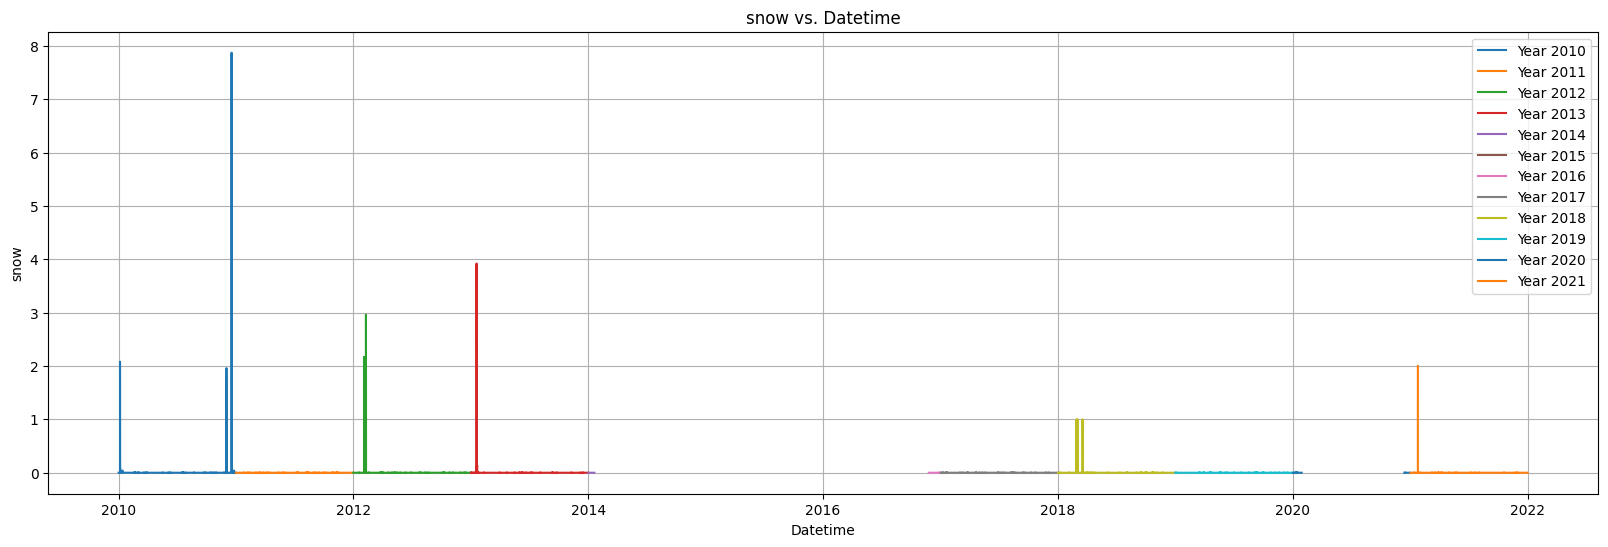

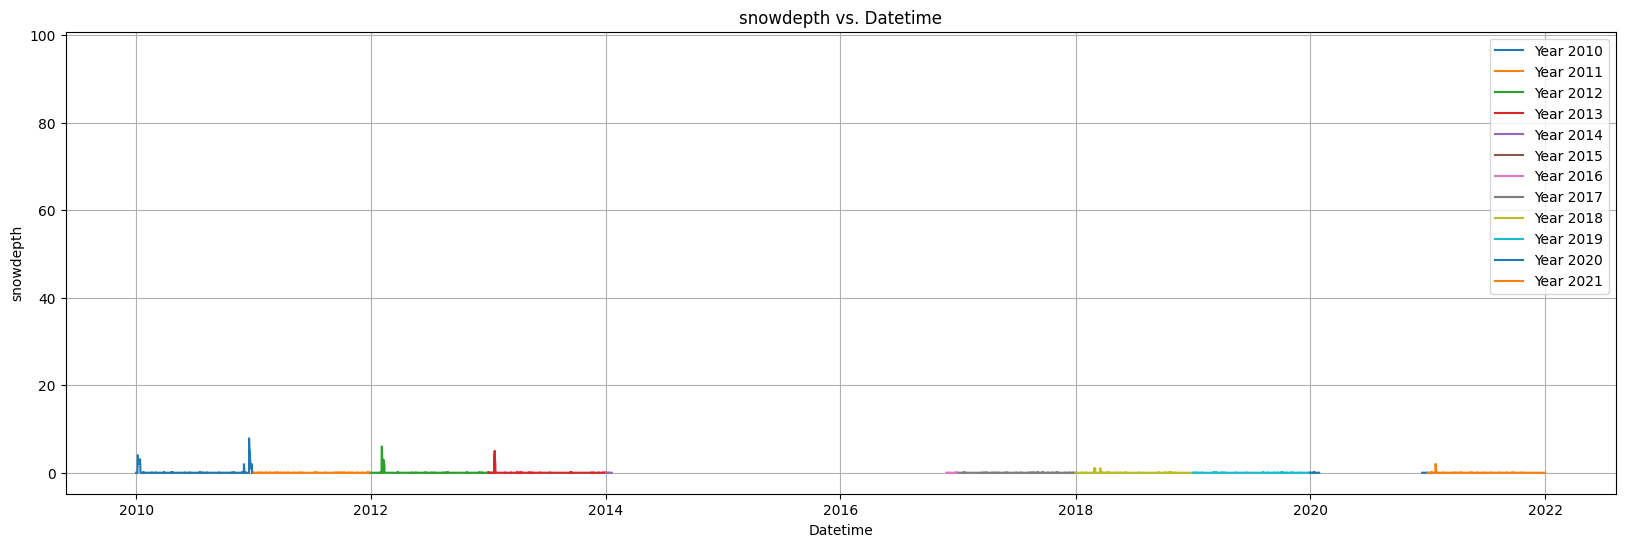

In [21]:
plot_data(X_train_weather_filled[['snow', 'snowdepth']])

In [22]:
# Extract 'snow' data for 2014, 2015 and 2016
years_to_fill = ['2014', '2015']
leap_years_to_fill = ['2016', '2020']

# Replace 'snow' data for 2014 and 2015 years with data from 2013
for year in years_to_fill:
    X_train_weather_filled.loc[year, 'snow'] = X_train_weather_filled.loc['2013', 'snow'].values
    X_train_weather_filled.loc[year, 'snowdepth'] = X_train_weather_filled.loc['2013', 'snowdepth'].values

# Replace 'snow' data for leap years 2016 and 2020 with data from 2012
for year in leap_years_to_fill:
    X_train_weather_filled.loc[year, 'snow'] = X_train_weather_filled.loc['2012', 'snow'].values
    X_train_weather_filled.loc[year, 'snowdepth'] = X_train_weather_filled.loc['2012', 'snowdepth'].values

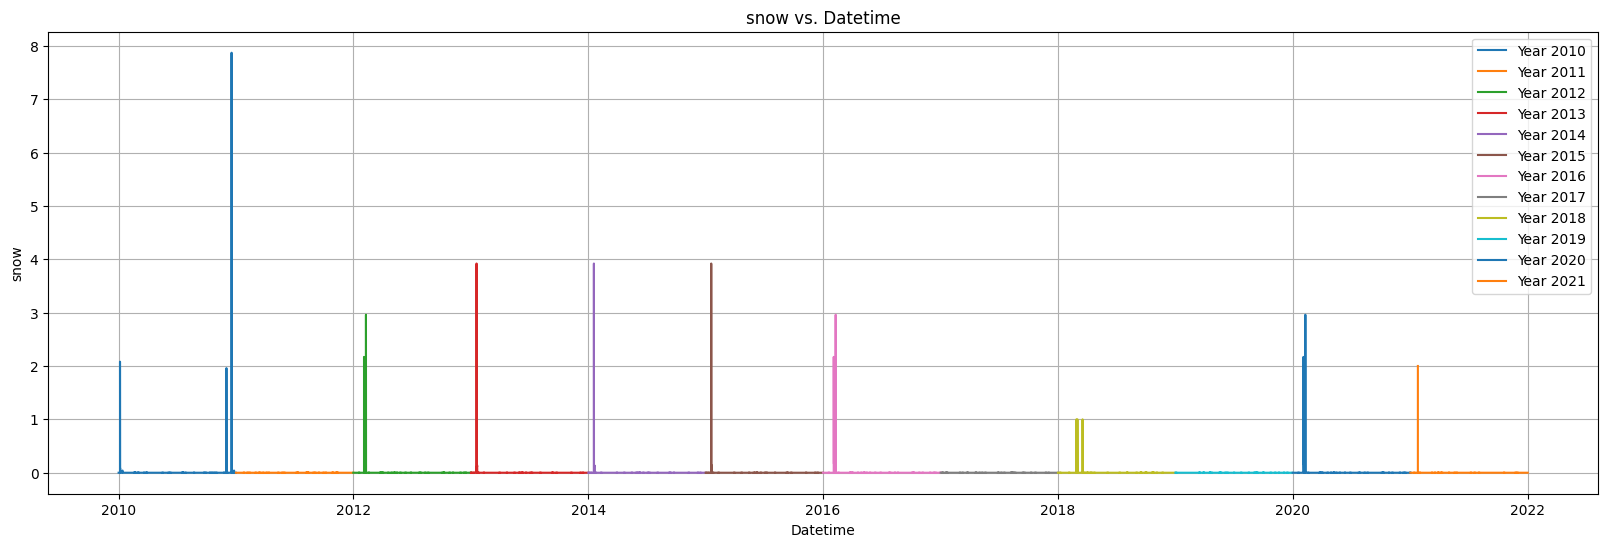

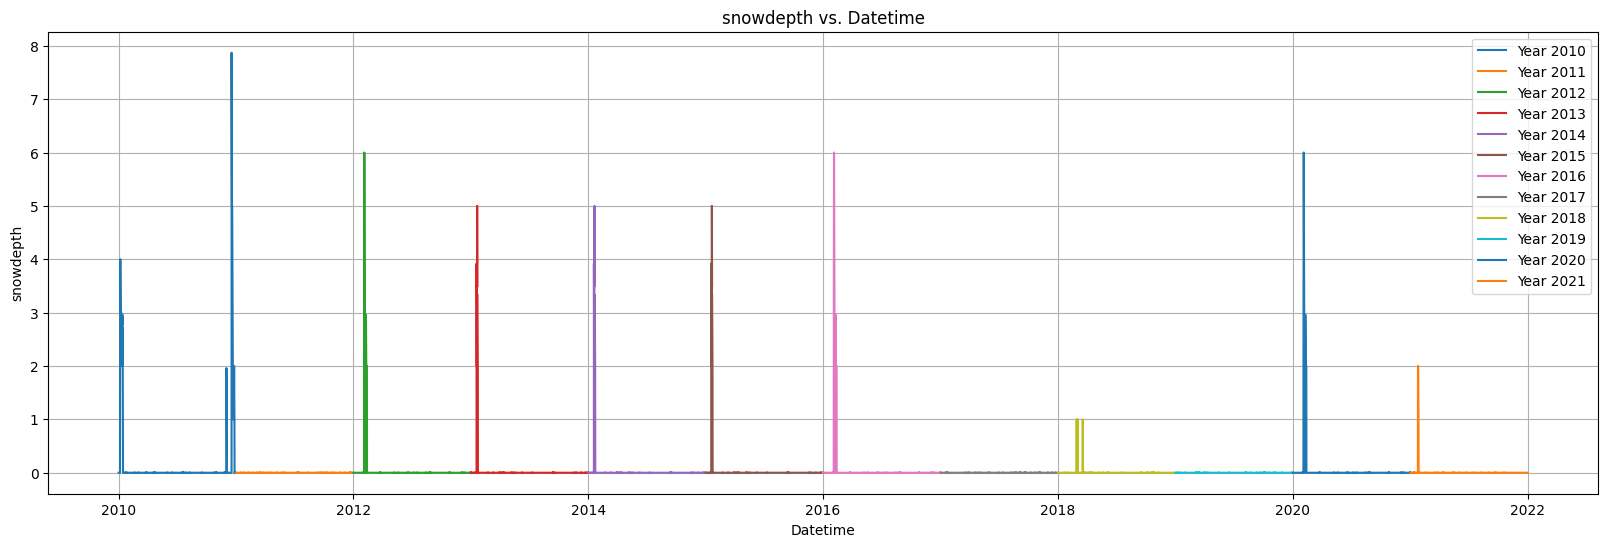

In [23]:
plot_data(X_train_weather_filled[['snow', 'snowdepth']])

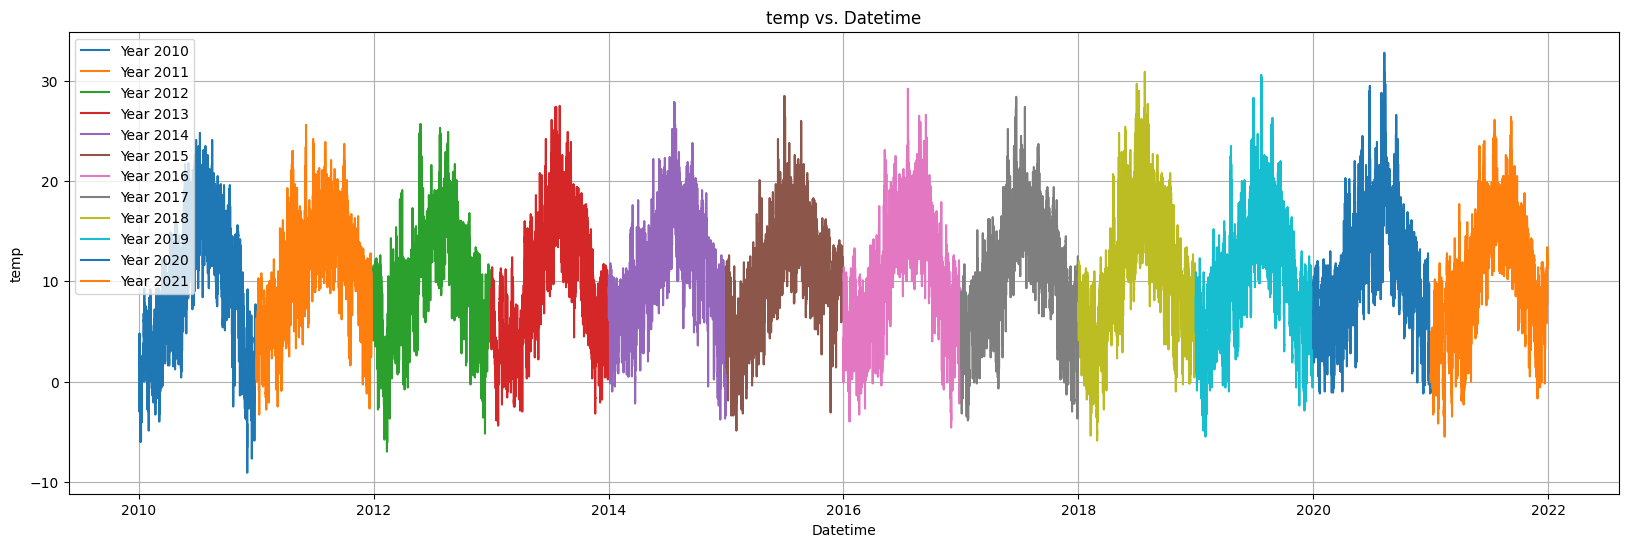

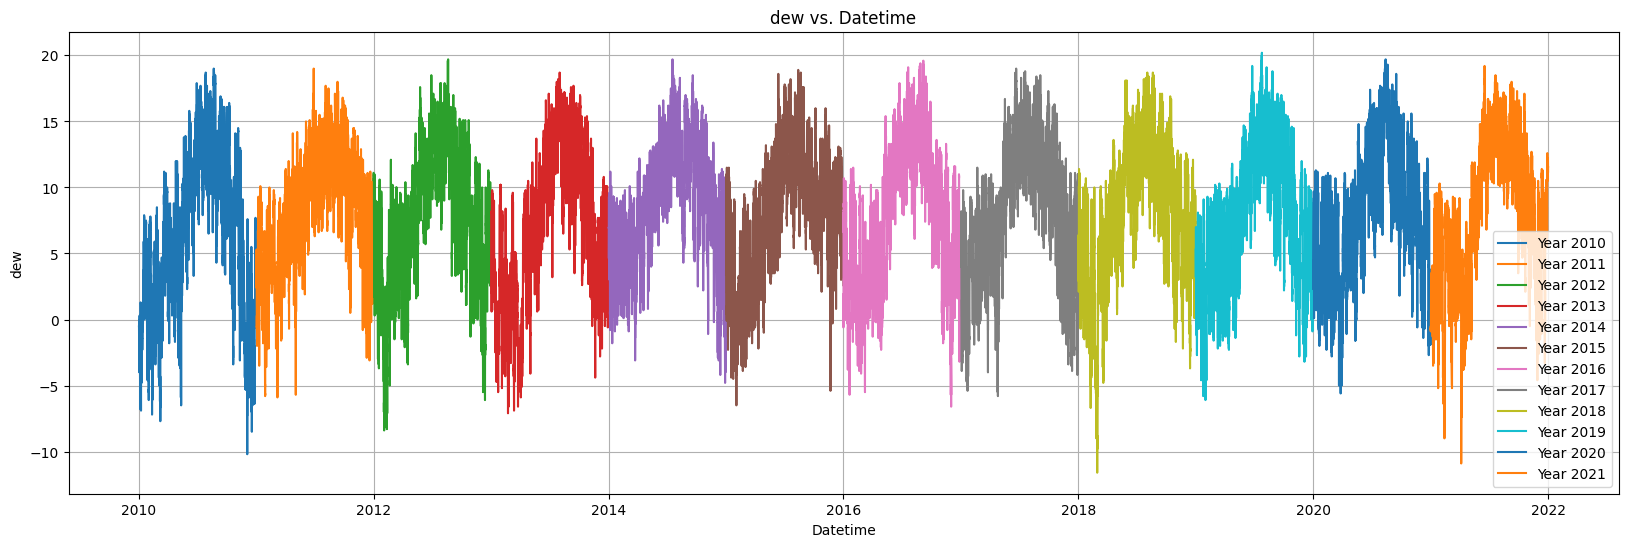

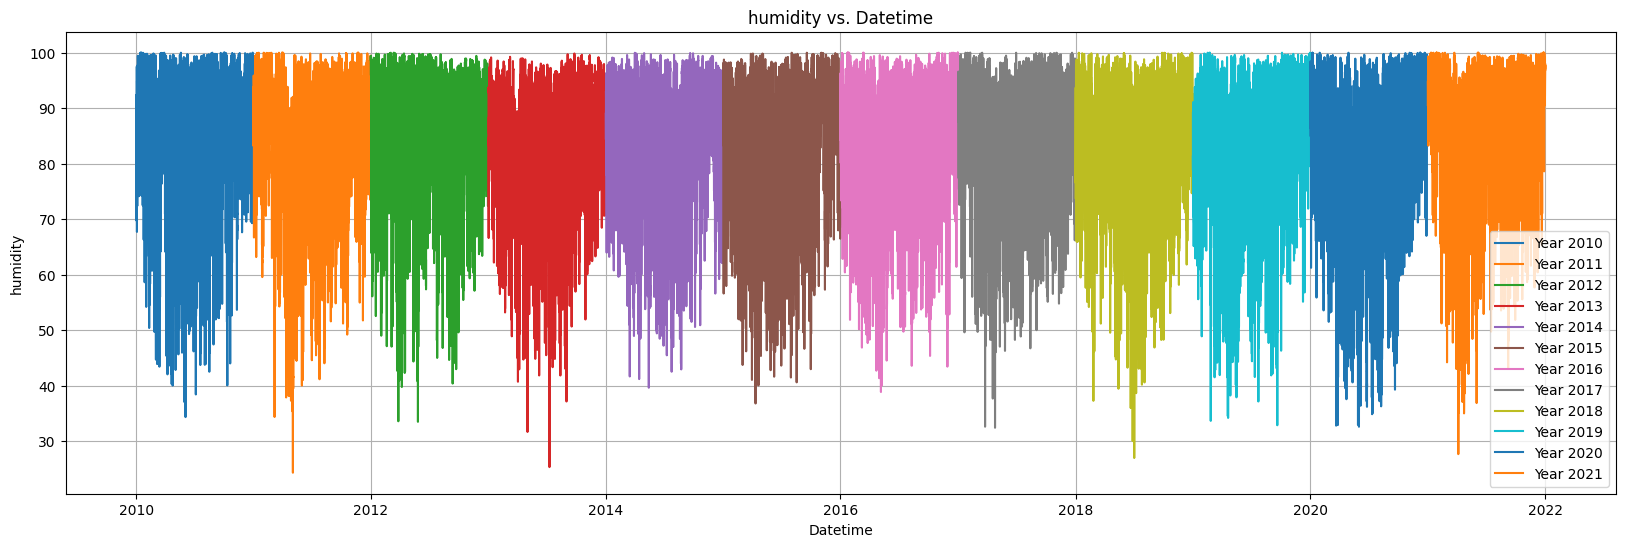

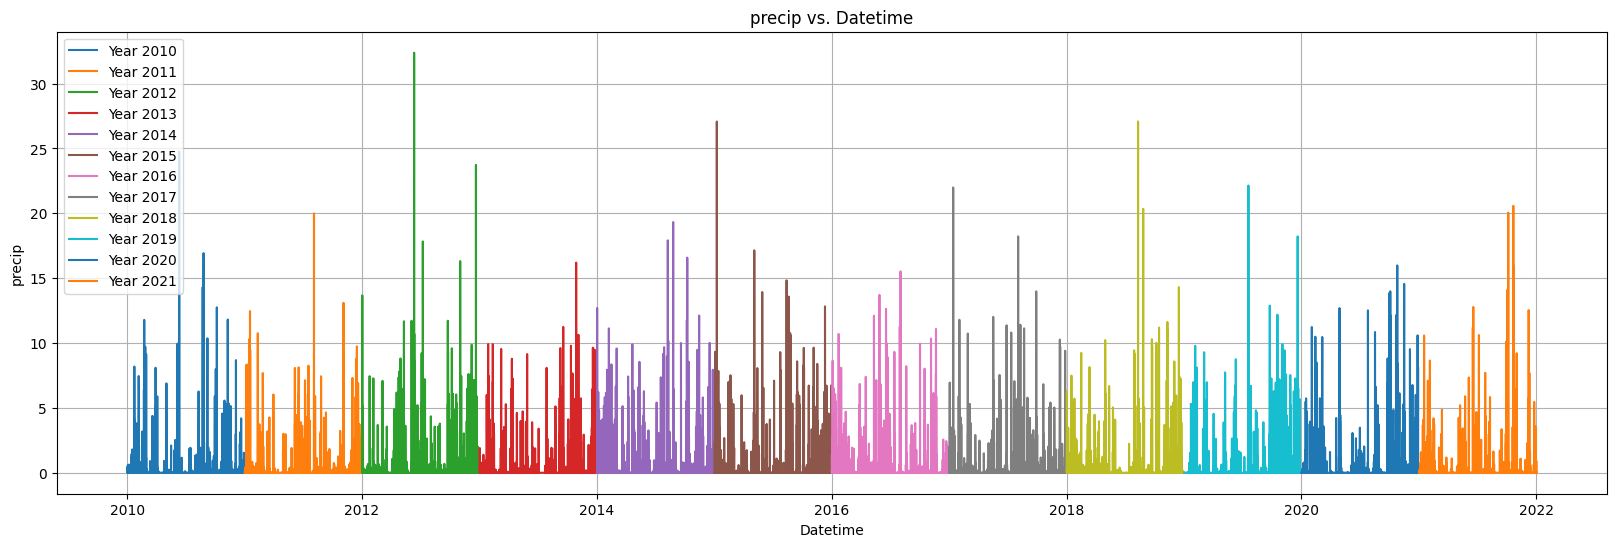

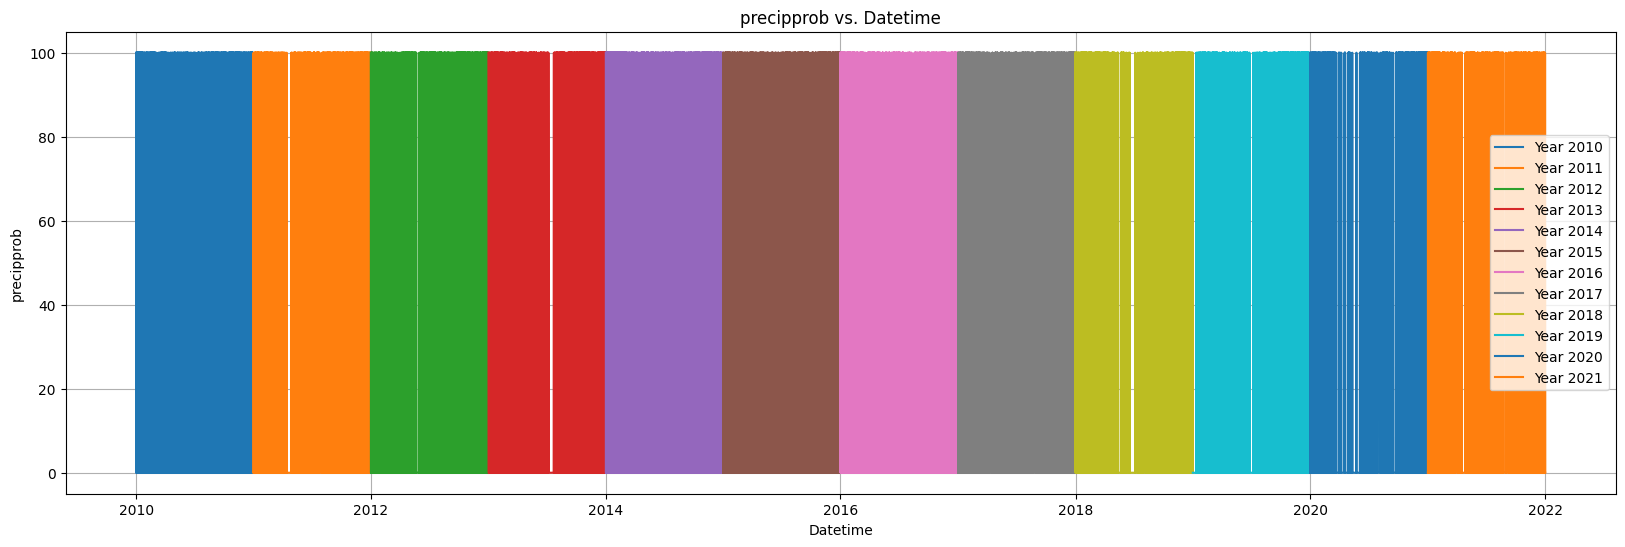

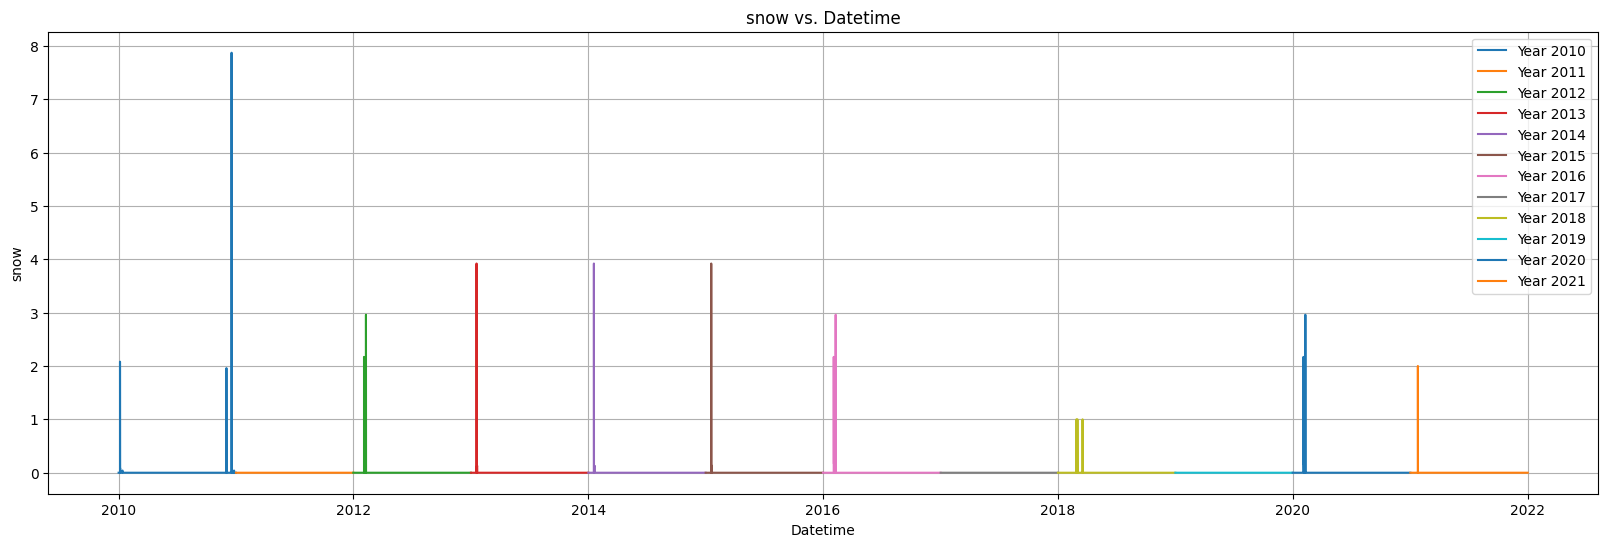

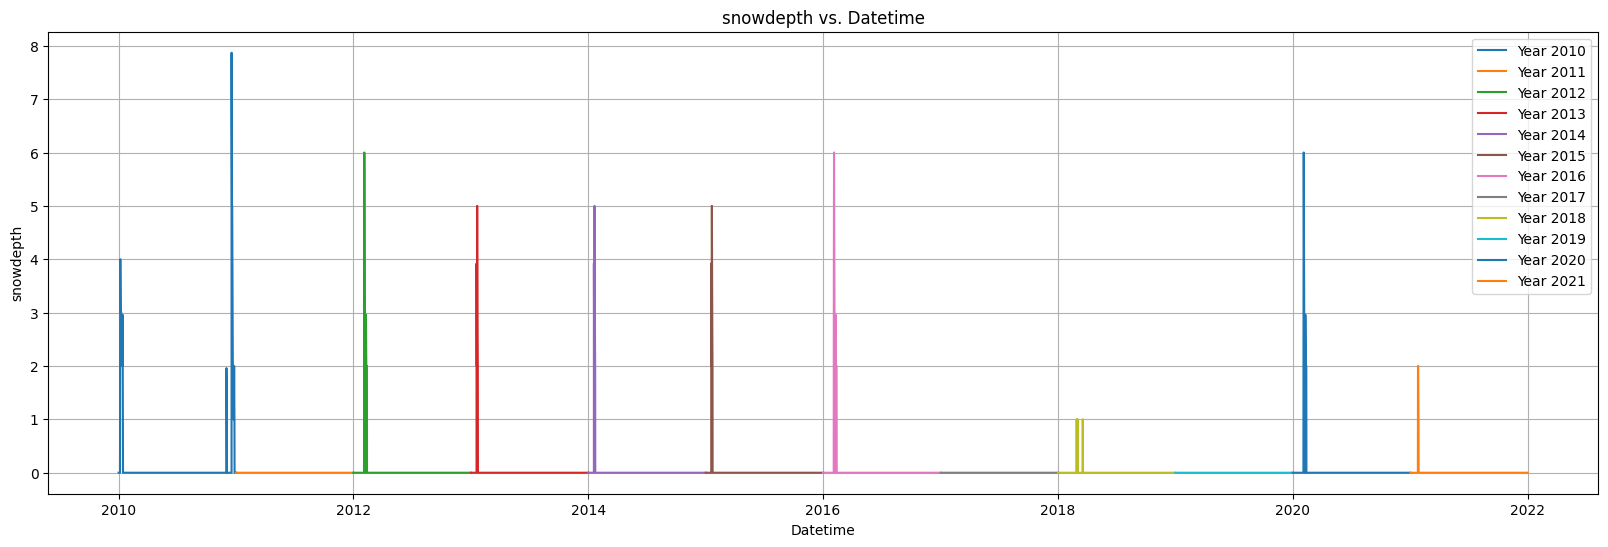

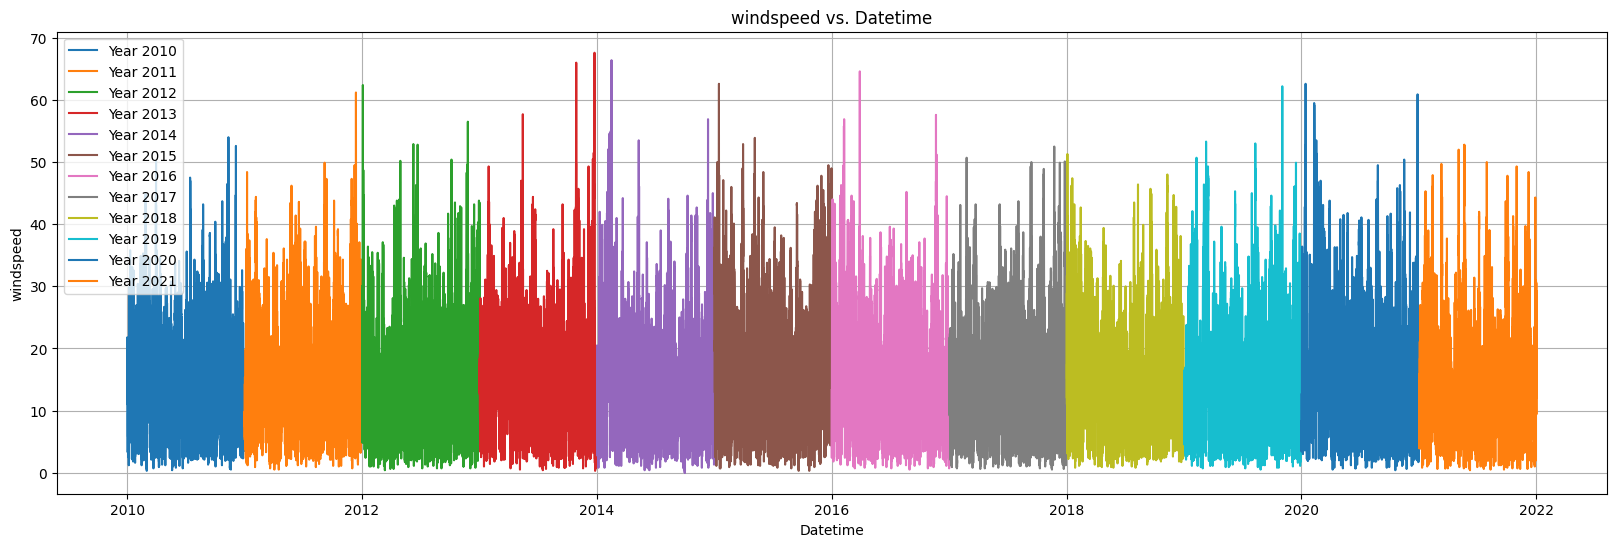

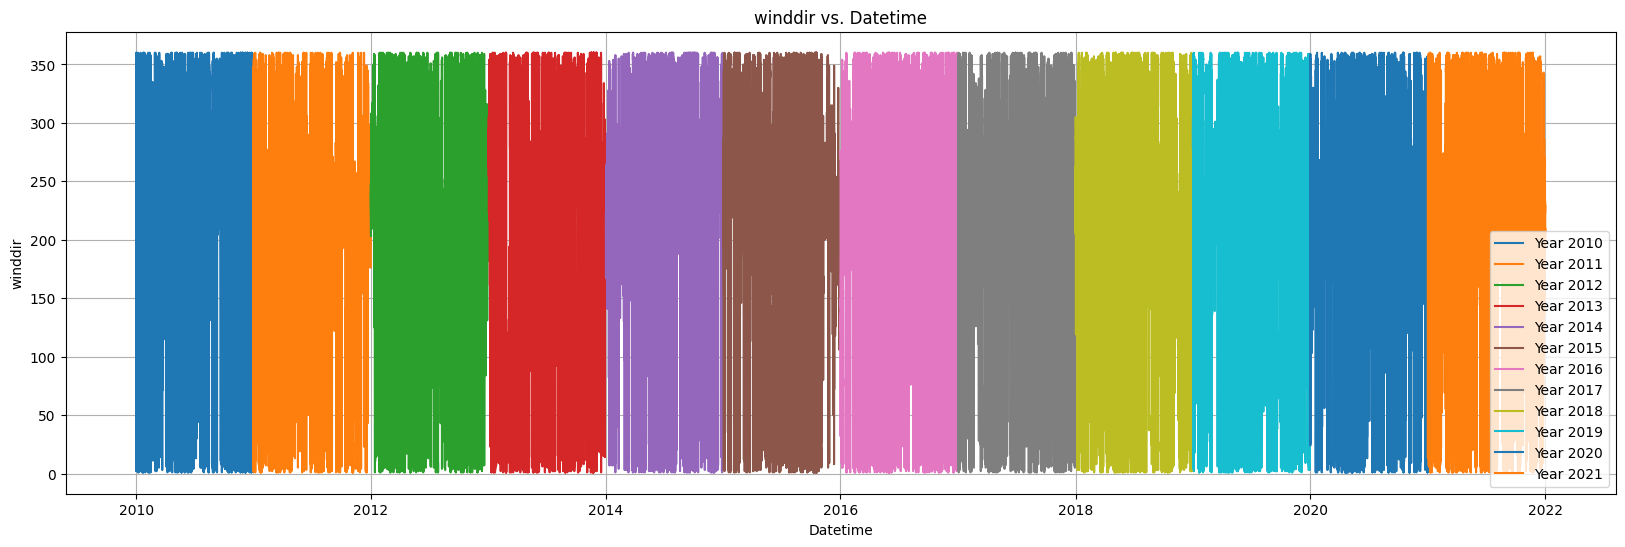

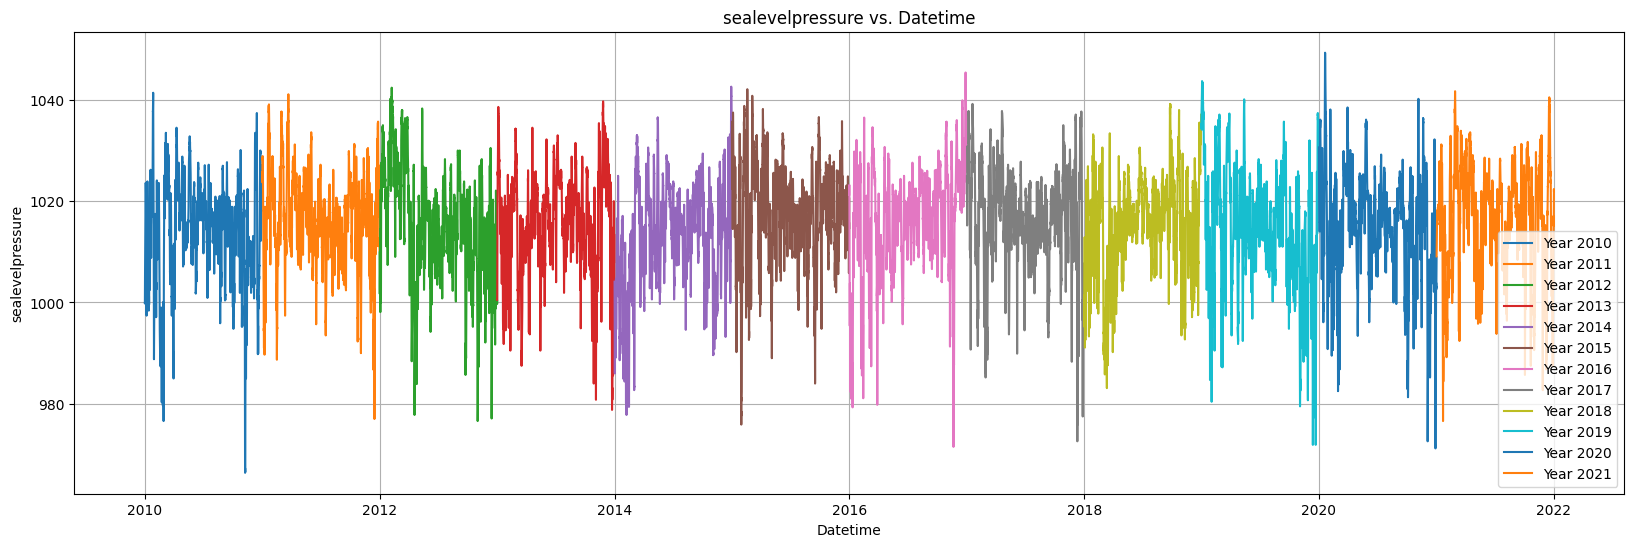

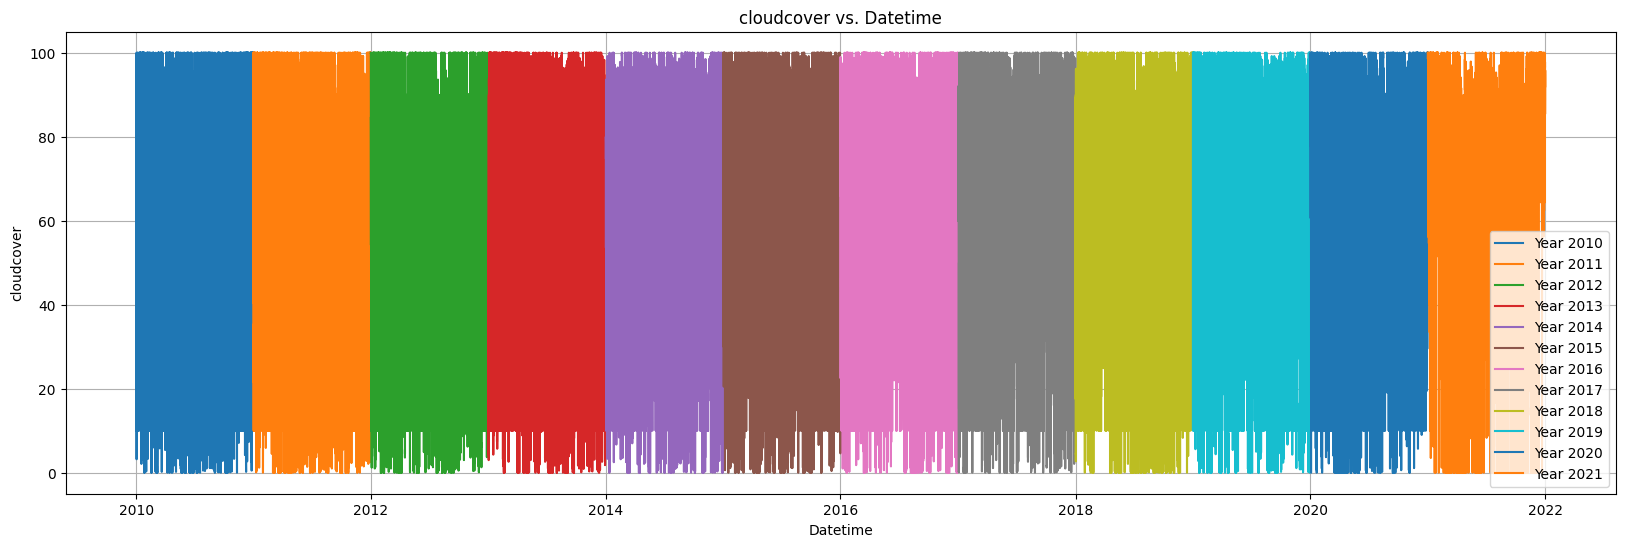

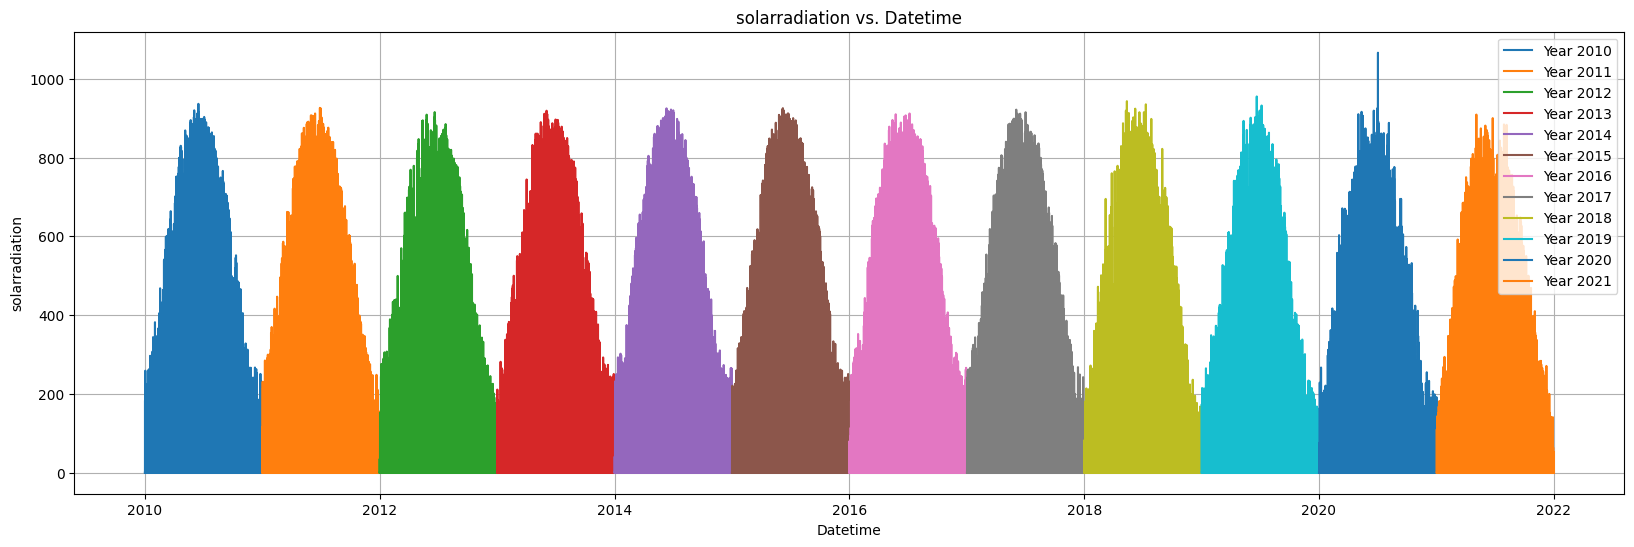

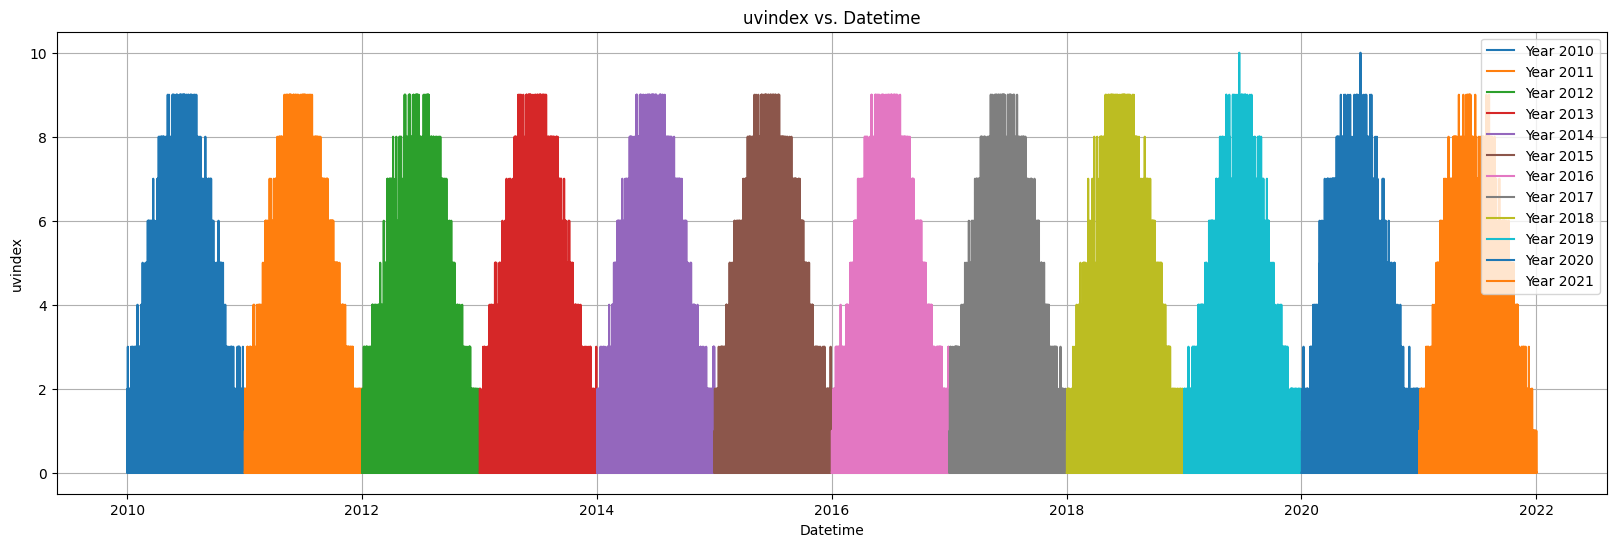

In [24]:
# columns to perform linear interpolation
data_interpolate = X_train_weather_filled
linear_interpolate_columns = data_interpolate.columns.values

# Perform linear interpolation
X_train_weather_filled[linear_interpolate_columns] = data_interpolate[linear_interpolate_columns].interpolate(method='linear')

# plot the data after filling NAN values using linear interpolation
plot_data(X_train_weather_filled)


After filling missing data with linear inetrpolation and 0 for snowdepth we have a clean dataset while preserving periodicity pattern in features

In [25]:
# confirm there are no missing values in columns
nan_count_by_year = X_train_weather_filled.groupby(X_train_weather_filled.index.year).apply(lambda x: x.isna().sum())
nan_count_by_year

temp  dew  humidity  precip  precipprob  snow  snowdepth  windspeed  \
datetime                                                                        
2010         0    0         0       0           0     0          0          0   
2011         0    0         0       0           0     0          0          0   
2012         0    0         0       0           0     0          0          0   
2013         0    0         0       0           0     0          0          0   
2014         0    0         0       0           0     0          0          0   
2015         0    0         0       0           0     0          0          0   
2016         0    0         0       0           0     0          0          0   
2017         0    0         0       0           0     0          0          0   
2018         0    0         0       0           0     0          0          0   
2019         0    0         0       0           0     0          0          0   
2020         0    0         0       0           0     0          0          0   
2021         0    0         0       0           0     0          0          0   

          winddir  sealevelpressure  cloudcover  solarradiation  uvindex  
datetime                                                                  
2010            0                 0           0               0        0  
2011            0                 0           0               0        0  
2012            0                 0           0               0        0  
2013            0                 0           0               0        0  
2014            0                 0           0               0        0  
2015            0                 0           0               0        0  
2016            0                 0           0               0        0  
2017            0                 0           0               0        0  
2018            0                 0           0               0        0  
2019            0                 0           0               0        0  
2020            0                 0           0               0        0  
2021            0                 0           0               0        0

### Calculate Wind and Solar energy

#### Wind Enegy

References for Wind Energy generation 
<br>
<https://www.e-education.psu.edu/emsc297/node/649#:~:text=We'll%20start%20with%20a,kW%20(8%20times%20as%20large)>
<br>
<https://www.ice.org.uk/engineering-resources/briefing-sheets/wind-energy>
<br><br>
Reference for Wind mills and rotor diameter
<br>
<https://rampionoffshorewindfarm.co.uk/key-facts/#:~:text=The%20Rampion%20Offshore%20Wind%20Farm,foundation%20fixed%20into%20the%20seabed.>

In [26]:
# function to calculate wind energy
def wind_energy(wind_speed):
    # Define parameters
    air_density = 1.225  # kg/m^3 (typical air density at sea level)
    swept_area =  np.pi * (15**2) # m^2 (assuming rotor diameter of the turbine is 30m, the swept area of the turbine)
    no_of_wind_mills = 116 # assuming there are 116 wind mills in Brigthon that produce wind energy
    print(swept_area)
    
    # Calculate wind energy in MW using the equation for each wind speed value
    wind_energy = (((0.5 * air_density * swept_area * (wind_speed * (1000 / 3600)) ** 3)/1000) * 100)/1000
    return round(wind_energy, 2)

X_train_weather_filled['windenergy'] = wind_energy(X_train_weather_filled['windspeed'])

# Display the DataFrame with wind energy calculation
X_train_weather_filled 

706.8583470577034


temp   dew  humidity  precip  precipprob  snow  \
datetime                                                              
2010-01-01 00:00:00   1.9  -0.5     84.25   0.417       100.0   0.0   
2010-01-01 01:00:00   1.9  -0.5     83.90   0.000         0.0   0.0   
2010-01-01 02:00:00   1.4  -0.7     85.76   0.000         0.0   0.0   
2010-01-01 03:00:00   1.4  -0.7     85.69   0.000         0.0   0.0   
2010-01-01 04:00:00   1.3  -0.8     85.72   0.000         0.0   0.0   
...                   ...   ...       ...     ...         ...   ...   
2021-12-31 19:00:00  11.9  11.5     97.73   0.000         0.0   0.0   
2021-12-31 20:00:00  12.0  11.6     97.65   0.000         0.0   0.0   
2021-12-31 21:00:00  11.7  11.4     97.75   0.000         0.0   0.0   
2021-12-31 22:00:00  11.7  11.4     97.75   0.000         0.0   0.0   
2021-12-31 23:00:00  11.7  11.2     96.89   0.000         0.0   0.0   

                     snowdepth  windspeed  winddir  sealevelpressure  \
datetime                                                               
2010-01-01 00:00:00        0.0       19.4     11.0             999.9   
2010-01-01 01:00:00        0.0       21.8     19.0             999.8   
2010-01-01 02:00:00        0.0       17.7     10.0            1000.0   
2010-01-01 03:00:00        0.0       18.0     11.0            1000.2   
2010-01-01 04:00:00        0.0       17.4     10.0            1000.5   
...                        ...        ...      ...               ...   
2021-12-31 19:00:00        0.0       15.8    219.0            1021.9   
2021-12-31 20:00:00        0.0       14.1    204.0            1022.1   
2021-12-31 21:00:00        0.0        9.4    203.0            1022.4   
2021-12-31 22:00:00        0.0       10.9    210.0            1022.1   
2021-12-31 23:00:00        0.0       12.1    202.0            1022.0   

                     cloudcover  solarradiation  uvindex  windenergy  
datetime                                                              
2010-01-01 00:00:00        62.2             0.0      0.0        6.78  
2010-01-01 01:00:00        22.4             0.0      0.0        9.61  
2010-01-01 02:00:00        38.0             0.0      0.0        5.15  
2010-01-01 03:00:00        66.7             0.0      0.0        5.41  
2010-01-01 04:00:00        62.8             0.0      0.0        4.89  
...                         ...             ...      ...         ...  
2021-12-31 19:00:00        93.6             0.0      0.0        3.66  
2021-12-31 20:00:00        94.4             0.0      0.0        2.60  
2021-12-31 21:00:00        90.3             0.0      0.0        0.77  
2021-12-31 22:00:00        95.8             0.0      0.0        1.20  
2021-12-31 23:00:00        92.0             0.0      0.0        1.64  

[105192 rows x 14 columns]

In [27]:
print(wind_energy(19.4))

706.8583470577034
6.78


#### Solar Enegy

Reference for Solar Energy generation 
<br><https://blog.ecoflow.com/us/how-to-calculate-solar-panel-output/>
<br><https://www.raymaps.com/index.php/how-to-calculate-the-area-required-by-solar-panels/>
<br><br>
Reference for no of sola energy panels
<br><https://www.brighton-hove.gov.uk/news/2023/hundreds-council-homes-switch-solar-power>

In [28]:
# function to calculate solar energy
def solar_energy(solar_radiation):
    
    # Define constants
    efficiency = 0.20  # 20%
    reduction_factor = 0.75  # 75% (percentage after considering all the factors(cloudcover, panel degradation) contributing to reduction of the panel output)
    panel_area = 30  # in square meters
    num_panels = 369 * 4 # considering 4 panels are installed in each 369 house and shops in brighton
    
    # Calculate solar energy in MW
    solar_energy = (solar_radiation* efficiency * reduction_factor * panel_area * num_panels)/1000000
    return round(solar_energy, 2)

X_train_weather_filled['solarenergy'] = solar_energy(X_train_weather_filled['solarradiation'])

# Display the DataFrame with solar energy calculation
X_train_weather_filled 

temp   dew  humidity  precip  precipprob  snow  \
datetime                                                              
2010-01-01 00:00:00   1.9  -0.5     84.25   0.417       100.0   0.0   
2010-01-01 01:00:00   1.9  -0.5     83.90   0.000         0.0   0.0   
2010-01-01 02:00:00   1.4  -0.7     85.76   0.000         0.0   0.0   
2010-01-01 03:00:00   1.4  -0.7     85.69   0.000         0.0   0.0   
2010-01-01 04:00:00   1.3  -0.8     85.72   0.000         0.0   0.0   
...                   ...   ...       ...     ...         ...   ...   
2021-12-31 19:00:00  11.9  11.5     97.73   0.000         0.0   0.0   
2021-12-31 20:00:00  12.0  11.6     97.65   0.000         0.0   0.0   
2021-12-31 21:00:00  11.7  11.4     97.75   0.000         0.0   0.0   
2021-12-31 22:00:00  11.7  11.4     97.75   0.000         0.0   0.0   
2021-12-31 23:00:00  11.7  11.2     96.89   0.000         0.0   0.0   

                     snowdepth  windspeed  winddir  sealevelpressure  \
datetime                                                               
2010-01-01 00:00:00        0.0       19.4     11.0             999.9   
2010-01-01 01:00:00        0.0       21.8     19.0             999.8   
2010-01-01 02:00:00        0.0       17.7     10.0            1000.0   
2010-01-01 03:00:00        0.0       18.0     11.0            1000.2   
2010-01-01 04:00:00        0.0       17.4     10.0            1000.5   
...                        ...        ...      ...               ...   
2021-12-31 19:00:00        0.0       15.8    219.0            1021.9   
2021-12-31 20:00:00        0.0       14.1    204.0            1022.1   
2021-12-31 21:00:00        0.0        9.4    203.0            1022.4   
2021-12-31 22:00:00        0.0       10.9    210.0            1022.1   
2021-12-31 23:00:00        0.0       12.1    202.0            1022.0   

                     cloudcover  solarradiation  uvindex  windenergy  \
datetime                                                               
2010-01-01 00:00:00        62.2             0.0      0.0        6.78   
2010-01-01 01:00:00        22.4             0.0      0.0        9.61   
2010-01-01 02:00:00        38.0             0.0      0.0        5.15   
2010-01-01 03:00:00        66.7             0.0      0.0        5.41   
2010-01-01 04:00:00        62.8             0.0      0.0        4.89   
...                         ...             ...      ...         ...   
2021-12-31 19:00:00        93.6             0.0      0.0        3.66   
2021-12-31 20:00:00        94.4             0.0      0.0        2.60   
2021-12-31 21:00:00        90.3             0.0      0.0        0.77   
2021-12-31 22:00:00        95.8             0.0      0.0        1.20   
2021-12-31 23:00:00        92.0             0.0      0.0        1.64   

                     solarenergy  
datetime                          
2010-01-01 00:00:00          0.0  
2010-01-01 01:00:00          0.0  
2010-01-01 02:00:00          0.0  
2010-01-01 03:00:00          0.0  
2010-01-01 04:00:00          0.0  
...                          ...  
2021-12-31 19:00:00          0.0  
2021-12-31 20:00:00          0.0  
2021-12-31 21:00:00          0.0  
2021-12-31 22:00:00          0.0  
2021-12-31 23:00:00          0.0  

[105192 rows x 15 columns]

In [29]:
# rearrange dataframe so windenergy and solarenegy columns will be at the end

# Extract the 'solarenergy' column
solar_energy_column = X_train_weather_filled.pop('solarenergy')

# Reinsert the 'solarenergy' column at the end of the DataFrame
X_train_weather_filled['solarenergy'] = solar_energy_column

## Plots after data cleaning and processing

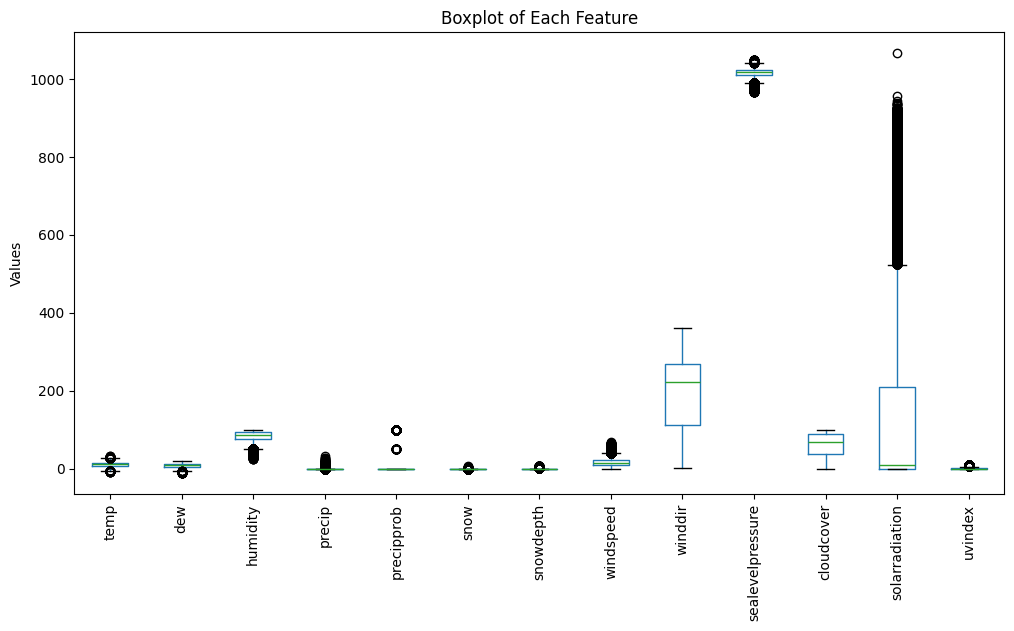

In [30]:
# boxplot of data after filling missing data
X_train_weather_filled[X_train_weather_filled.columns[:-2]].boxplot(figsize=(12, 6), grid=False)
plt.title('Boxplot of Each Feature')
plt.ylabel('Values')
plt.xticks(rotation=90)
plt.show()

From the boxplot we can see that humidity, windspeed, winddir, sealevelpresure, cloudcover and solarradiation are in different scales and solarradiation has lot of outliers.

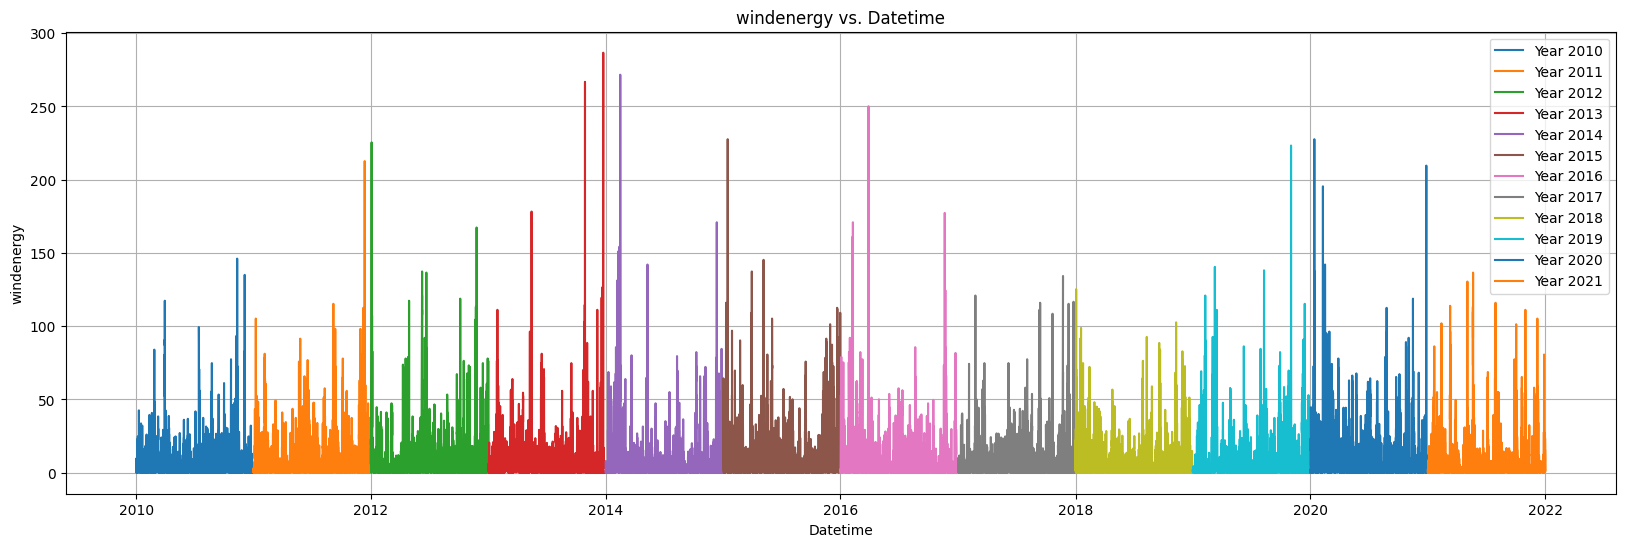

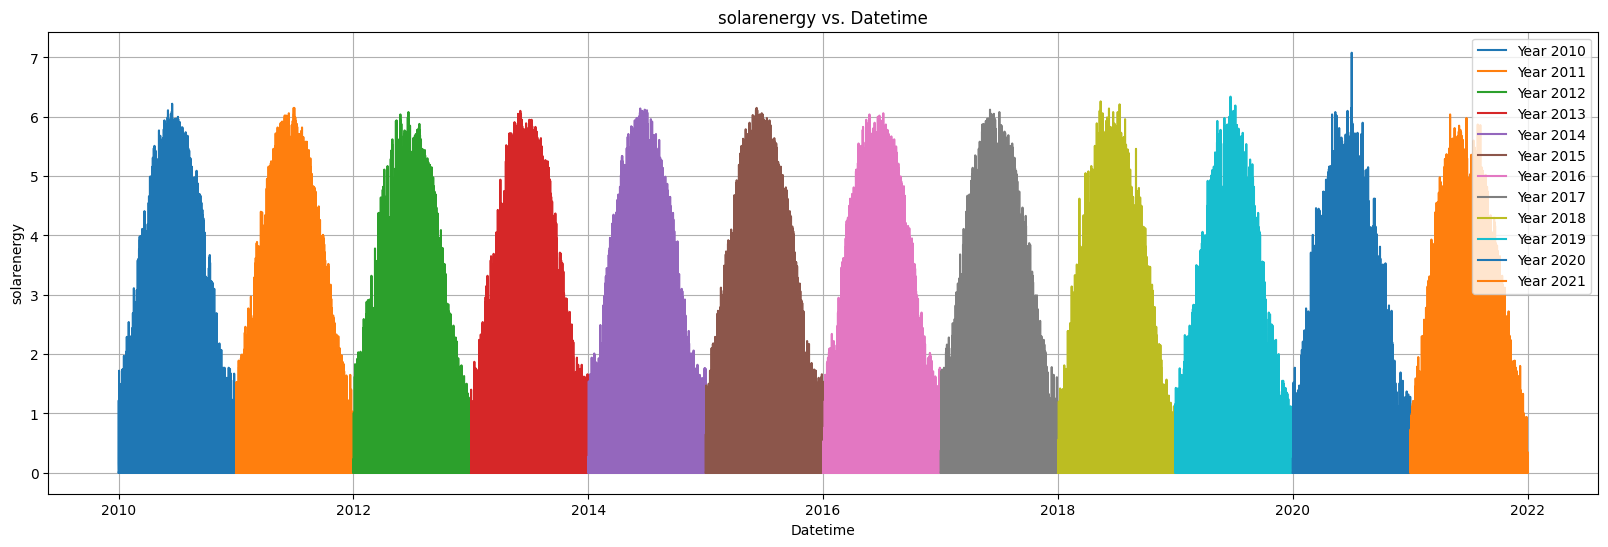

In [31]:
# Plot windenergy and solarenergy agains datetime
plot_data(X_train_weather_filled[['windenergy', 'solarenergy']])

In the solarenergy plot we can clearly see the periodicity throughout the years. We can also see somewhat pattern in wind energy but not as clearly in solarenergy.

### Explore Mutual Information

             Feature  Solar Energy MI  Wind Energy MI
0               temp         0.134171        0.036954
1                dew         0.032672        0.014606
2           humidity         0.152248        0.061033
3             precip         0.005930        0.006065
4         precipprob         0.000000        0.004497
5               snow         0.000000        0.000359
6          snowdepth         0.000000        0.000000
7          windspeed         0.036670        5.706475
8            winddir         0.025843        0.134353
9   sealevelpressure         0.020750        0.063730
10        cloudcover         0.030437        0.033676
11    solarradiation         3.951341        0.038014
12           uvindex         1.474289        0.039123


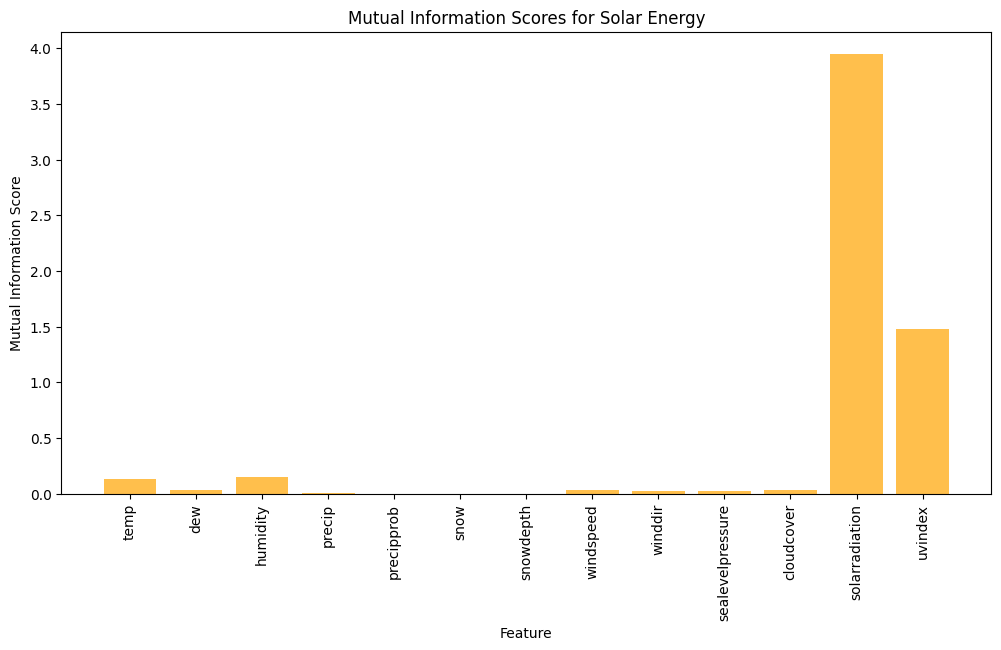

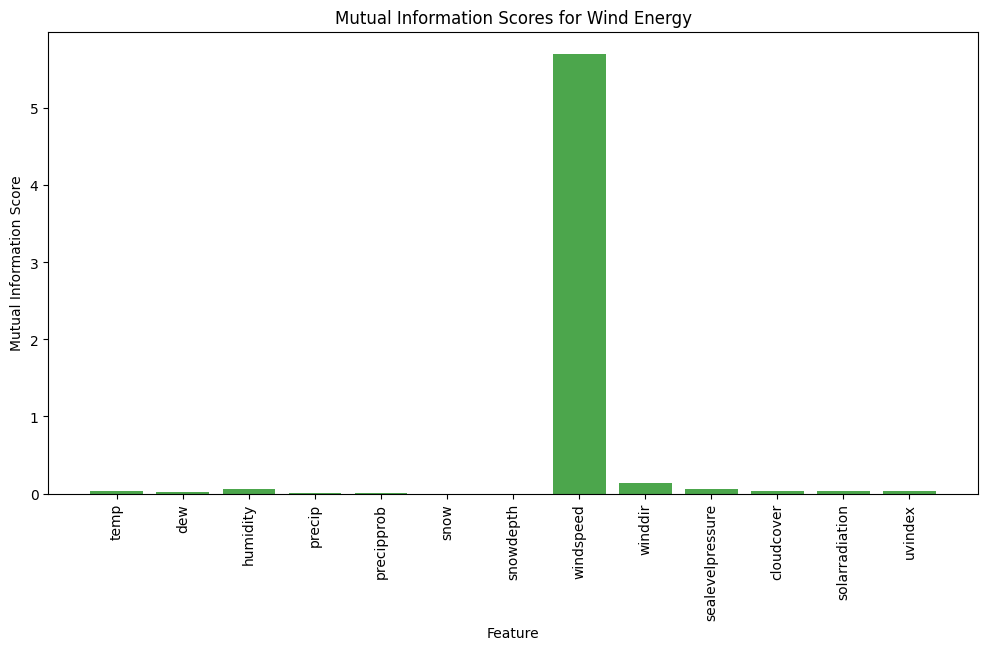

In [32]:
# calculate mutual information scores for solarenergy and windenergy
x_features =  X_train_weather_filled.iloc[:, :-2]

#shift the y values by 24 rows because we analayze the correlation between features with the target values after 24h
y_solar_energy = X_train_weather_filled.iloc[:, -1:].shift(24).dropna() 
y_wind_energy = X_train_weather_filled.iloc[:, -2:-1].shift(24).dropna()

# Ensure x_features has the same length as y_solar_energy and y_wind_energy
x_features = x_features.iloc[:len(y_solar_energy)]

# Calculate mutual information for solar energya
mi_solar_energy = mutual_info_regression(x_features, y_solar_energy)

# Calculate mutual information for wind energy
mi_wind_energy = mutual_info_regression(x_features, y_wind_energy)

# Create a DataFrame to store the mutual information scores
mi_scores = pd.DataFrame({'Feature': x_features.columns, 'Solar Energy MI': mi_solar_energy, 'Wind Energy MI': mi_wind_energy})

print(mi_scores)

# Plot bar chart for mutual information scores of solar energy
plt.figure(figsize=(12, 6))
plt.bar(mi_scores['Feature'], mi_scores['Solar Energy MI'], color='orange', alpha=0.7)
plt.title('Mutual Information Scores for Solar Energy')
plt.xlabel('Feature')
plt.ylabel('Mutual Information Score')
plt.xticks(rotation=90)
plt.show()

# Plot bar chart for mutual information scores of wind energy
plt.figure(figsize=(12, 6))
plt.bar(mi_scores['Feature'], mi_scores['Wind Energy MI'], color='green', alpha=0.7)
plt.title('Mutual Information Scores for Wind Energy')
plt.xlabel('Feature')
plt.ylabel('Mutual Information Score')
plt.xticks(rotation=90)
plt.show()

#### Mutual information for Solar Energy
Mutual information gives the amount of information obtained through the knowledge of one variable about another varaible.
Not like correlation it can detect the linear and non linear relationship between variables. And we have shifted the target variable rows by 24 because we try to predict the energy for 24h in advance using current feature values.
looking at the mutual information scores of solar energy we can see that solarradiation is highly important when predicting solar energy compared to other features.
apart from solarradiation, uvindex  has the second highest mi_score which says it is also potentially informative when predicting solarenergy temp, dew, humidity, windspeed, winddir, sealevelpressure, cloudcover has lower mi_scores compared to solarradiation and uvindex.
precip, precipprob, snow, snowdepth have lower mi_scores which explain that these features does not contain much information about solar energy.

#### Mutual information for Wind Energy
looking at the mutual information scores of windenergy we can see that windspeed has the highest mis_score means that it is highly important when predicting wind energy. 
<br>winddir has the second highest mi_score which says it is also potentially informative when predicting windenergy.
<br>precipprob, snow and snowdepth have the lowest mi_score while 0 mi_score in snow for wind energy which means that there is only slight or no realtionship between these factors and windenergy

Then to have a unified training dataset the cleaned and processed dataset is saved to cleaned_weather_data.csv file

In [33]:
X_train_weather_filled.to_csv("cleaned_weather_data.csv")

## Seasonal Plots

In [34]:
# Resample 'solarenergy' and 'windenergy' columns for each month, taking the average
avg_monthly_energy = pd.DataFrame()
avg_monthly_energy['solarenergy'] = X_train_weather_filled['solarenergy'].resample('M').mean()
avg_monthly_energy['windenergy'] = X_train_weather_filled['windenergy'].resample('M').mean()

# Display the new DataFrame
print(avg_monthly_energy)

            solarenergy  windenergy
datetime                           
2010-01-31     0.251465    4.204032
2010-02-28     0.423214    7.043065
2010-03-31     0.839019    7.423898
2010-04-30     1.499514    5.727583
2010-05-31     1.764113    3.942177
...                 ...         ...
2021-08-31     1.058011    6.305161
2021-09-30     0.824014    4.594625
2021-10-31     0.470215    9.566478
2021-11-30     0.269000    4.567347
2021-12-31     0.132446    7.239745

[144 rows x 2 columns]


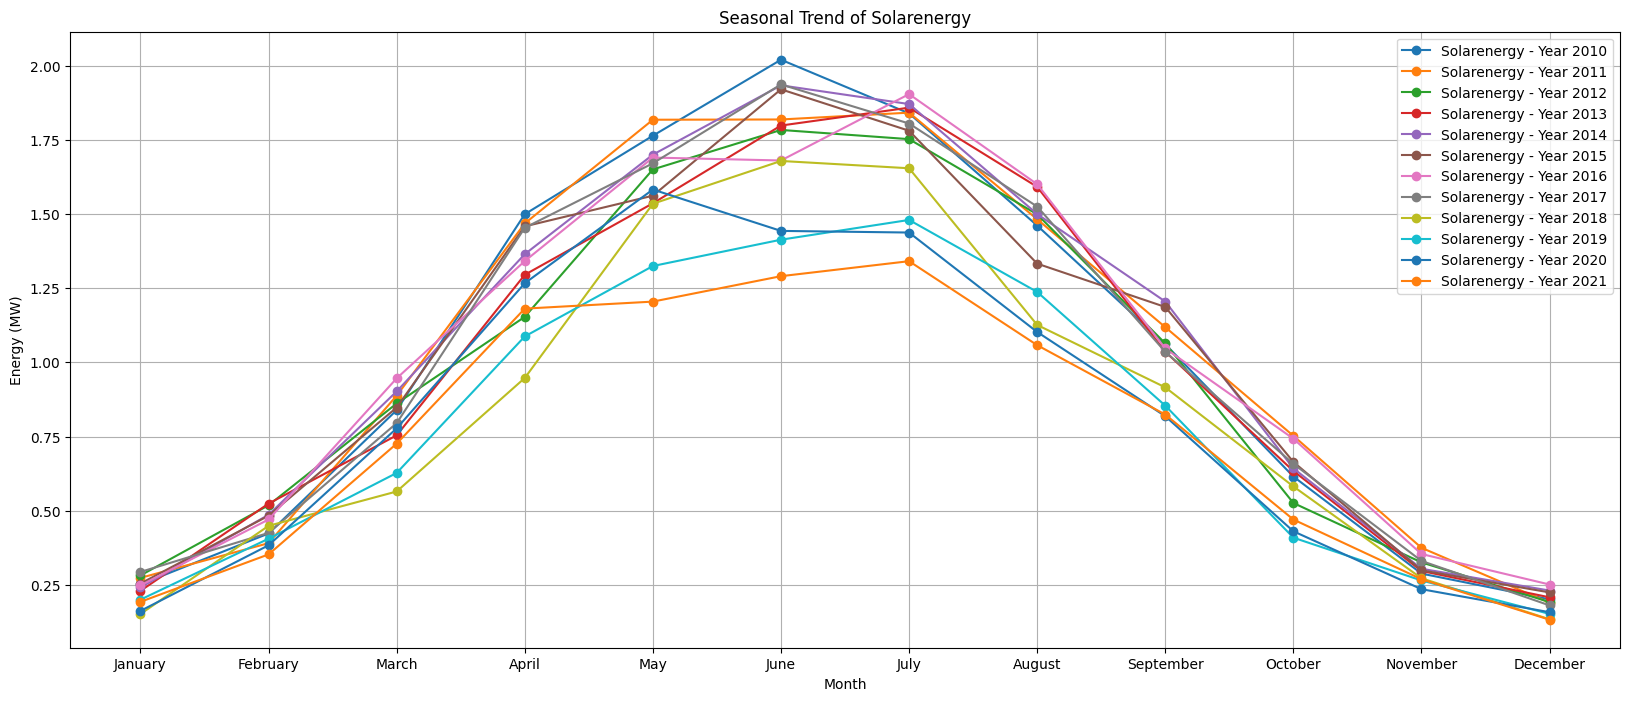

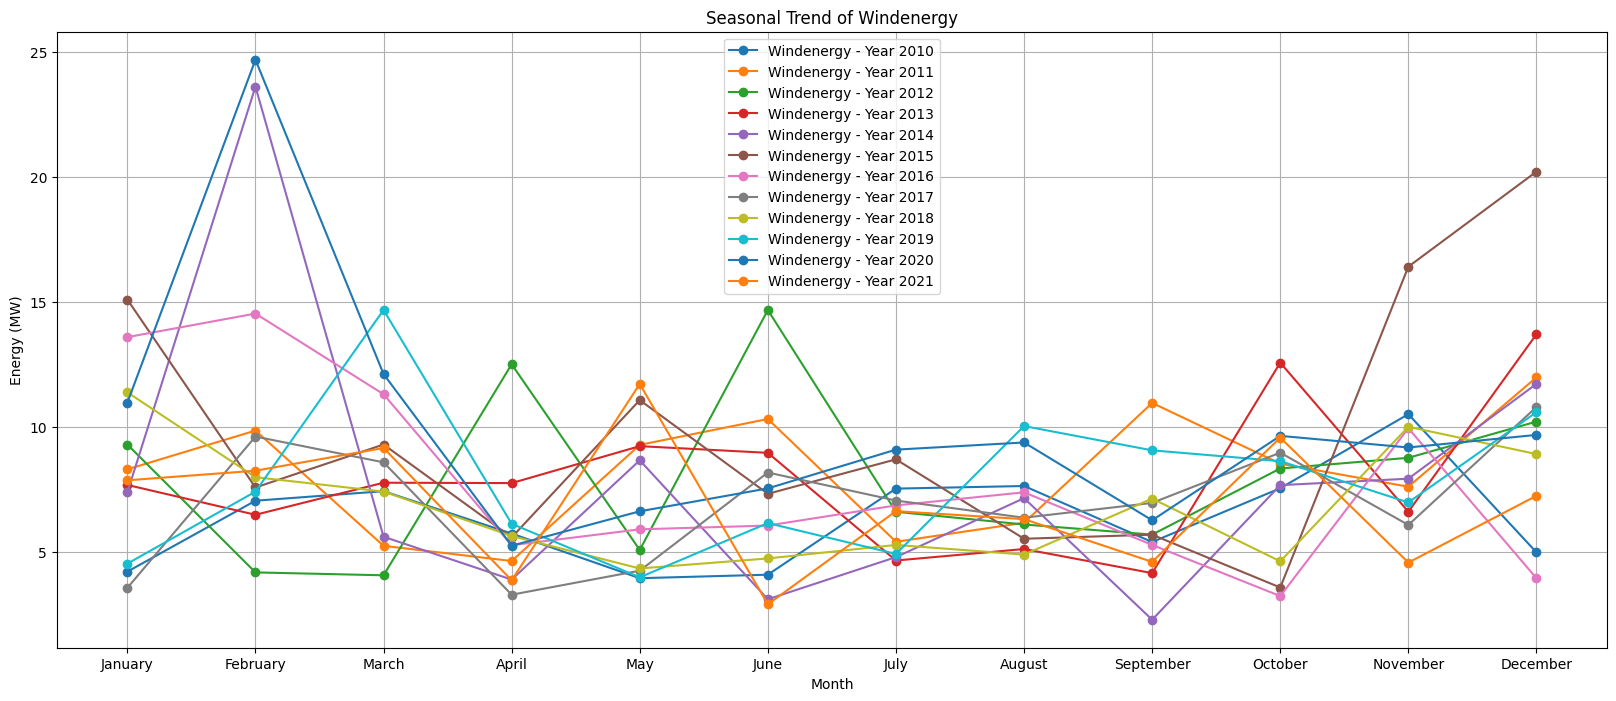

In [35]:
# Group data by year for plotting
grouped_by_year = avg_monthly_energy.groupby(avg_monthly_energy.index.year)

# Define energy sources
energy_sources = ['solarenergy', 'windenergy']

# Create a plot for each energy source
for energy_source in energy_sources:
    plt.figure(figsize=(20, 8))
    
    # Plot data for each year
    for year, group in grouped_by_year:
        plt.plot(group.index.month, group[energy_source], marker='o', linestyle='-', label=f'{energy_source.capitalize()} - Year {year}')
    
    # Set plot title, axis labels, and legend
    plt.title(f'Seasonal Trend of {energy_source.capitalize()}')
    plt.xlabel('Month')
    plt.ylabel('Energy (MW)')
    plt.xticks(range(1, 13), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
    plt.legend()
    plt.grid(True)
    plt.show()

#### Seasonal trend of Solar Energy
We can see that from January to June the solar energy generation is increasing and in most of the years enter to a peak value in June. Then the solar energy generation decreases until December. It indicates that in sumary times solar energy generation is at it's maximum and in windter times it is the lowest.

#### Seasonal trend of Wind Energy
According to the seasonal trent of wind energy plot drawn against monthof each year it depict that first and fourth quarters of the year produces the high wind energy. some clear exception can be seen in 2012 data.

<br>
Since we cannot see a much pattern in the seasonal trend of Windenergy, let's plot the wind energy for a specific day on each year.
we'll take the day as 1st of January

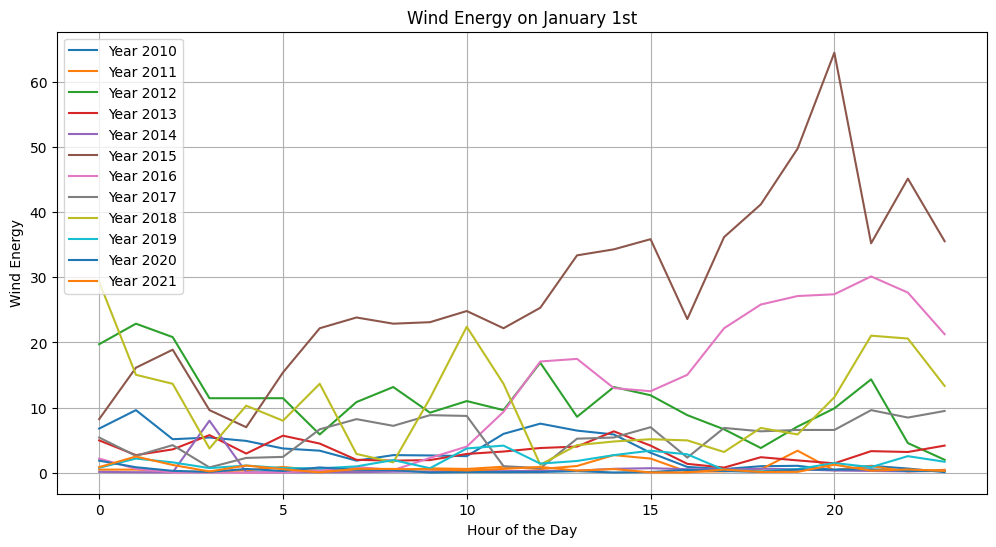

In [36]:
# Filter the DataFrame for the specific day
wind_energy_specific_day = X_train_weather_filled[(X_train_weather_filled.index.month == 1) & (X_train_weather_filled.index.day == 1)]

# Iterate through each year and plot wind energy
plt.figure(figsize=(12, 6))
for year, group in wind_energy_specific_day.groupby(wind_energy_specific_day.index.year):
    plt.plot(group.index.hour, group['windenergy'], label=f'Year {year}')

# Add labels and legend
plt.title(f'Wind Energy on January 1st')
plt.xlabel('Hour of the Day')
plt.ylabel('Wind Energy')
plt.legend()
plt.grid(True)
plt.show()

Even from the above plot we cannot see a much patter in wind energy. we can say that in 2015 the winds are higher compared to other years

## Timeseries Decomposition

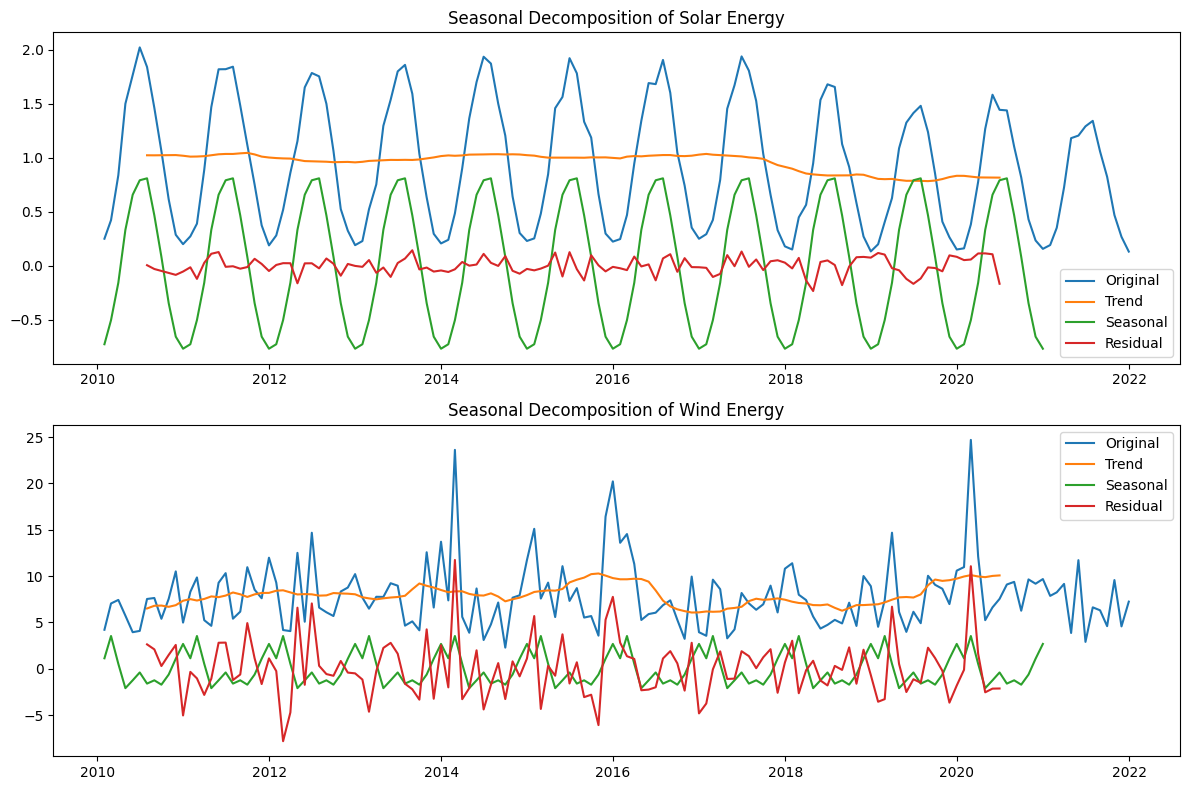

In [37]:
# Decompose solar energy
decomposition_solar = seasonal_decompose(avg_monthly_energy.loc['2010':'2020', 'solarenergy'], model='additive', period=12)

# Decompose wind energy
decomposition_wind = seasonal_decompose(avg_monthly_energy.loc['2010':'2020', 'windenergy'], model='additive', period=12)

# Plot the decompositions
plt.figure(figsize=(12, 8))

# Solar energy decomposition
plt.subplot(2, 1, 1)
plt.plot(avg_monthly_energy['solarenergy'], label='Original')
plt.plot(decomposition_solar.trend, label='Trend')
plt.plot(decomposition_solar.seasonal, label='Seasonal')
plt.plot(decomposition_solar.resid, label='Residual')
plt.title('Seasonal Decomposition of Solar Energy')
plt.legend()

# Wind energy decomposition
plt.subplot(2, 1, 2)
plt.plot(avg_monthly_energy['windenergy'], label='Original')
plt.plot(decomposition_wind.trend, label='Trend')
plt.plot(decomposition_wind.seasonal, label='Seasonal')
plt.plot(decomposition_wind.resid, label='Residual')
plt.title('Seasonal Decomposition of Wind Energy')
plt.legend()

plt.tight_layout()
plt.show()


In the seasonal decomposition of solar energy it clearly depicts seasonal trends in original as well as seasonal component in each year. But in seasonal decomposition of wind energy we can see somewhat seasonal trend in the seasonal component but not as much as clear in solar energy. 

## Stationarity check

In [38]:
adf_result_solar_energy = adfuller(avg_monthly_energy.loc['2010':'2020', 'solarenergy'])  # ADF test on the full years only.
print('ADF results for solar energy')
print('ADF Statistic %.2f:' % adf_result_solar_energy[0])
print('ADF p-value: %.4f:' % adf_result_solar_energy[1])

adf_result_wind_energy = adfuller(avg_monthly_energy.loc['2010':'2020', 'windenergy'])  # ADF test on the full years only.
print('\nADF results for wind energy')
print('ADF Statistic %.2f:' % adf_result_wind_energy[0])
print('ADF p-value: %.4f:' % adf_result_wind_energy[1])

ADF results for solar energy
ADF Statistic -0.52:
ADF p-value: 0.8874:

ADF results for wind energy
ADF Statistic -9.30:
ADF p-value: 0.0000:


<br>The null hypothesis is that the timeseries has a unit root.
<br>If the choose the significance level as 0.05, p-value of solar energy(0.8874) > 0.05 means we fail to reject the null hypothesis and the time series for solar energy is NOT-stationary
<br>P-value of wind energy(0.00000) < 0.05 means we can reject the null hypothesis and the timeseries  for wind energy is stationary
<br>Therefore, we can say that the statistical properties of solar energy is likely tio be changed over time while they will not be chnaged over time in wind energy.

## Auto Correlation

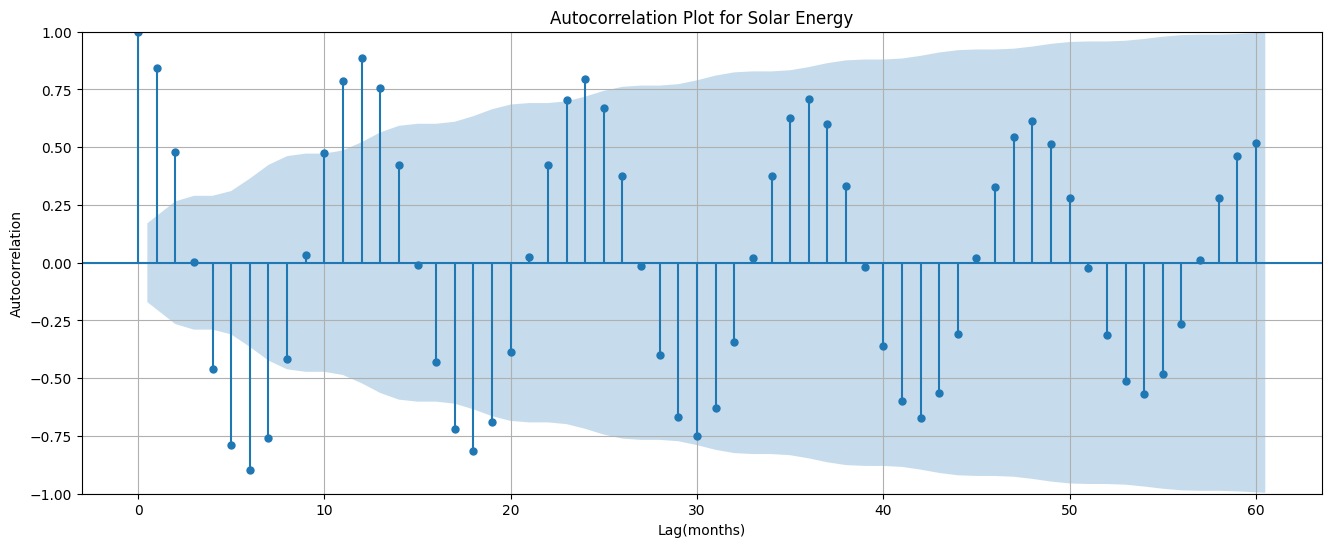

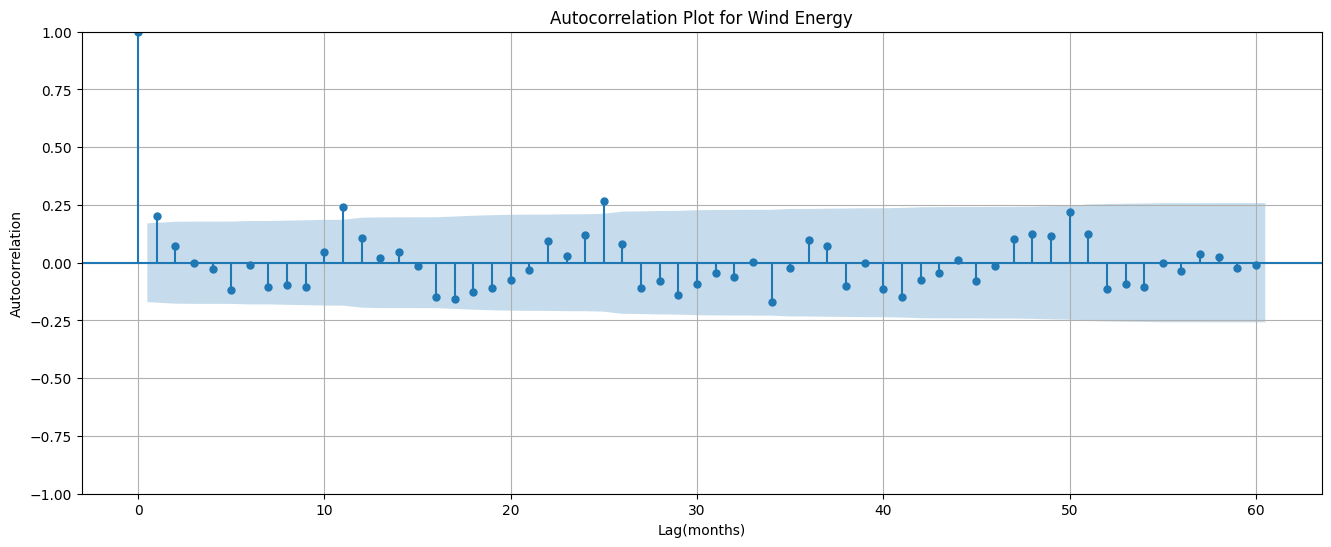

In [39]:
# Plot autocorrelation for solar energy
fig, ax  = plt.subplots(figsize=(16, 6))
plot_acf(avg_monthly_energy.loc['2010':'2020', 'solarenergy'], lags=60, alpha=0.05, ax=ax) # considering 5 years of past data
plt.title('Autocorrelation Plot for Solar Energy')
plt.xlabel('Lag(months)')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# Plot autocorrelation for wind energy
fig, ax  = plt.subplots(figsize=(16, 6))
plot_acf(avg_monthly_energy.loc['2010':'2020', 'windenergy'], lags=60, alpha=0.05, ax=ax) # considering 5 years of past data
plt.title('Autocorrelation Plot for Wind Energy')
plt.xlabel('Lag(months)')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

#### Autocorrelation plot for Solar Energy
The graph is plotted considering 4 years(60 months) of lag or time delay. 
plot shows the strength of the correlation between generated solar energy of the current month and previous month generated solar energy.
By looking at the plot we can see that at lag 1 coefficient of autocorrelation is positive and significant, meaning solar energy of current momth is positively correlated with the previous month. Again another peak occurs at lag 6 which is 6 month ago with negative correaltion coefficent, this indicats that there is an inverse relationship between generated solar energy in current month and 6 month before. possibly in summer times solar energy generayion is higher compared to winter times.
This autocorrelation plot clearly depicts the seasonal patterns of solar energy.
<br> points outside the blue shaded area are statistically significant

#### Autocorrelation plot for Wind Energy
The graph is plotted considering 5 years(60 months) of lag or time delay. 
plot shows the strength of the correlation between generated wind energy of the current month and previous month generated wind energy.
By looking at the plot we can see that at lag 1 coefficient of autocorrelation is positive and significant, 
meaning wind energy of current momth is positively correlated with the previous month. 
Again another peak occurs at lag 6 which is 6 month ago with negative correaltion coefficent, 
this indicates that there is an inverse relationship between generated wind energy in current month and 6 month before.
But in this autocorrelation plot, it doesn't show a clear seasonal patterns of wind energy.
<br> points outside the blue shaded area are statistically significant

## Partial Auto Correlation

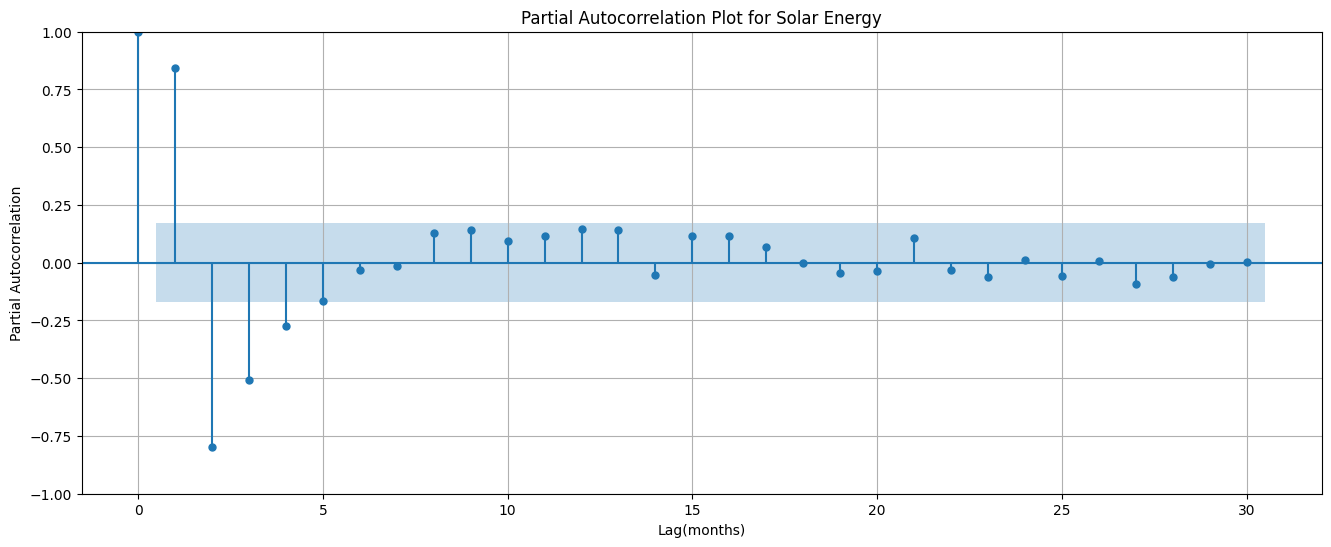

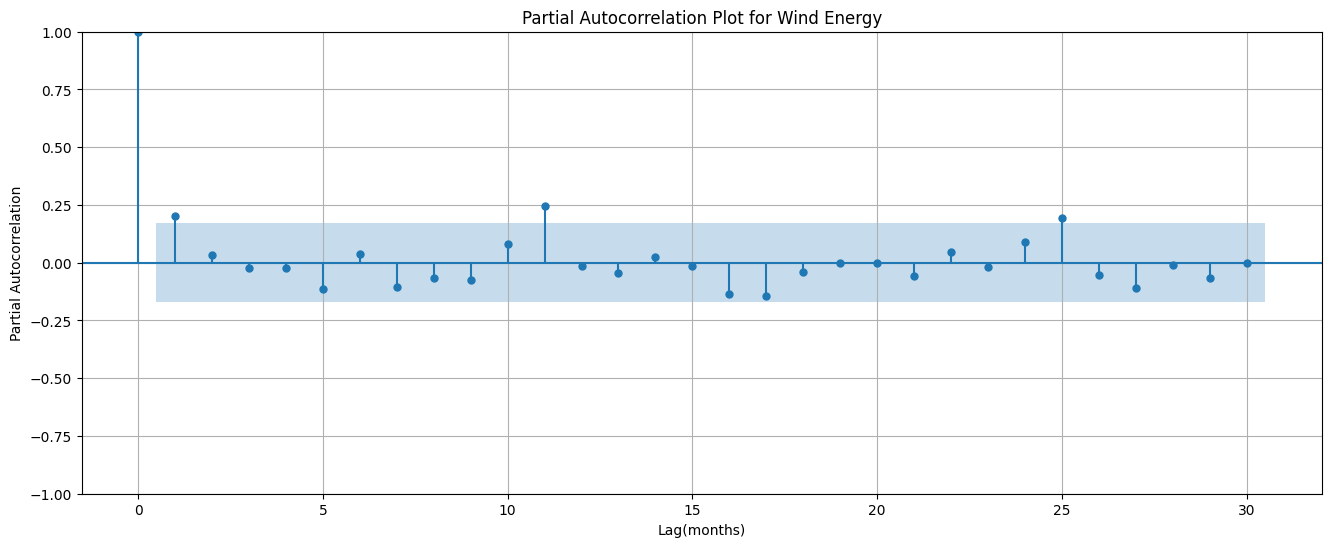

In [40]:
# Plot PACF for solar energy
fig, ax  = plt.subplots(figsize=(16, 6))
plot_pacf(avg_monthly_energy.loc['2010':'2020', 'solarenergy'], lags=30, ax=ax,title='Partial Autocorrelation Plot for Solar Energy')
plt.xlabel('Lag(months)')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

# Plot PACF for wind energy
fig, ax  = plt.subplots(figsize=(16, 6))
plot_pacf(avg_monthly_energy.loc['2010':'2020', 'windenergy'], lags=30,ax=ax, title='Partial Autocorrelation Plot for Wind Energy')
plt.xlabel('Lag(months)')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

#### Partial autocorrelation plot for Solar Energy
PACF gives direct correlation beween solar energy of the current month and lagged values by removing the influence of immediate lagged values. point outside the significant bands which is the blue shaded area indicates the significant paartial auto correaltion values. lags 1-5 are statistically significant whilst lag 6 is nearly significant. Rest of the lags are within the significant bands. From the pattern we can say that it indicates an autoregreesive term of order 5.

#### Partial autocorrelation plot for Wind Energy
Lag 1, 11 and 25 indicate nearly significannce in wind energy PCFA. Rest of the lags are within the significant bands and they are insignificant.

For wind and solar energy forcasting models we can evaluate ARIMA, SARIMA models

## Electricity surplus Reaserch

In [41]:
# add totalenergy column by adding windenergy and solarenergy
X_train_weather_filled['totalenergy'] = X_train_weather_filled['windenergy'] + X_train_weather_filled['solarenergy']
X_train_weather_filled

X_train_weather_filled[X_train_weather_filled['totalenergy'] == X_train_weather_filled['totalenergy'].max()]

temp  dew  humidity  precip  precipprob  snow  snowdepth  \
datetime                                                                        
2013-12-24 02:00:00  10.7  9.2     90.46     0.0         0.0   0.0        0.0   

                     windspeed  winddir  sealevelpressure  cloudcover  \
datetime                                                                
2013-12-24 02:00:00       67.6    197.0             979.1        81.5   

                     solarradiation  uvindex  windenergy  solarenergy  \
datetime                                                                
2013-12-24 02:00:00             0.0      0.0      286.66          0.0   

                     totalenergy  
datetime                          
2013-12-24 02:00:00       286.66

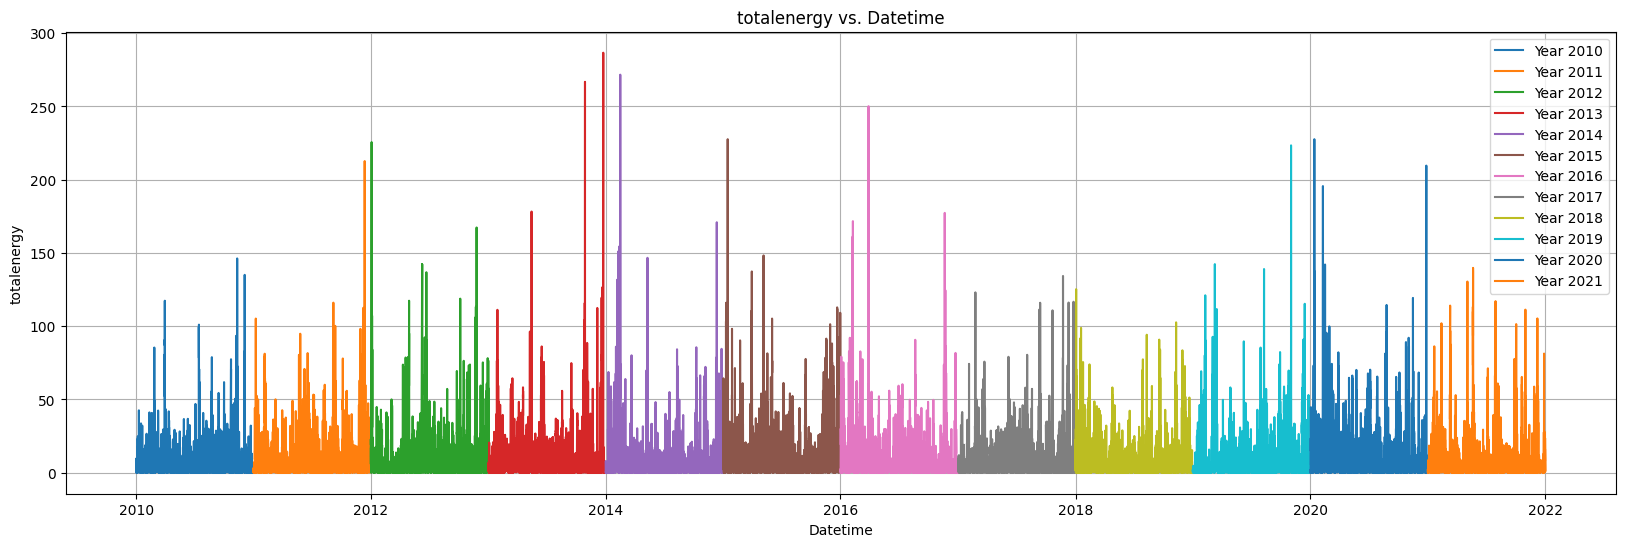

In [42]:
# plot totalenergy over time
plot_data(X_train_weather_filled[['totalenergy']])

Reference for average household electricity usage per day in the UK
<br>https://www.utilitybidder.co.uk/compare-business-energy/what-is-the-average-household-energy-usage/#:~:text=What%20is%20the%20average%20electricity,factors%20that%20affect%20this%20figure.
<br><br>Reference for no of households in Brighton
<br>https://www.brighton-hove.gov.uk/sites/default/files/migrated/subject/inline/downloads/citystats/4_Housing.pdf

From the reference of average household electricity usage in the UK, we can say that there is nearly 10KWh of average daily electricity demand. After taking the hourly kW amount, the value is equivalent to 0.417kW. Since the energy is calculated in MW, average hourly household energy usage is for 114479 households is 47.73MW. Also we can consider the consumer behaviour and multiply this value by a constant factor of 2. 
Therefore we can take the cutoff or the threshold value for total energy as 95.48MW to define if there is a surplus or not.
If the total energy exceeds 95.48MW there is a surplus and shorage otherwise.

In [43]:
# function to determine surplus
def determine_surplus(total_energy):
    if total_energy > (0.417/1000)*114479*2:
        return 1
    else:
        return 0

# Apply function to create the 'surplus' column
X_train_weather_filled['surplus'] = X_train_weather_filled['totalenergy'].apply(determine_surplus)
X_train_weather_filled

temp   dew  humidity  precip  precipprob  snow  \
datetime                                                              
2010-01-01 00:00:00   1.9  -0.5     84.25   0.417       100.0   0.0   
2010-01-01 01:00:00   1.9  -0.5     83.90   0.000         0.0   0.0   
2010-01-01 02:00:00   1.4  -0.7     85.76   0.000         0.0   0.0   
2010-01-01 03:00:00   1.4  -0.7     85.69   0.000         0.0   0.0   
2010-01-01 04:00:00   1.3  -0.8     85.72   0.000         0.0   0.0   
...                   ...   ...       ...     ...         ...   ...   
2021-12-31 19:00:00  11.9  11.5     97.73   0.000         0.0   0.0   
2021-12-31 20:00:00  12.0  11.6     97.65   0.000         0.0   0.0   
2021-12-31 21:00:00  11.7  11.4     97.75   0.000         0.0   0.0   
2021-12-31 22:00:00  11.7  11.4     97.75   0.000         0.0   0.0   
2021-12-31 23:00:00  11.7  11.2     96.89   0.000         0.0   0.0   

                     snowdepth  windspeed  winddir  sealevelpressure  \
datetime                                                               
2010-01-01 00:00:00        0.0       19.4     11.0             999.9   
2010-01-01 01:00:00        0.0       21.8     19.0             999.8   
2010-01-01 02:00:00        0.0       17.7     10.0            1000.0   
2010-01-01 03:00:00        0.0       18.0     11.0            1000.2   
2010-01-01 04:00:00        0.0       17.4     10.0            1000.5   
...                        ...        ...      ...               ...   
2021-12-31 19:00:00        0.0       15.8    219.0            1021.9   
2021-12-31 20:00:00        0.0       14.1    204.0            1022.1   
2021-12-31 21:00:00        0.0        9.4    203.0            1022.4   
2021-12-31 22:00:00        0.0       10.9    210.0            1022.1   
2021-12-31 23:00:00        0.0       12.1    202.0            1022.0   

                     cloudcover  solarradiation  uvindex  windenergy  \
datetime                                                               
2010-01-01 00:00:00        62.2             0.0      0.0        6.78   
2010-01-01 01:00:00        22.4             0.0      0.0        9.61   
2010-01-01 02:00:00        38.0             0.0      0.0        5.15   
2010-01-01 03:00:00        66.7             0.0      0.0        5.41   
2010-01-01 04:00:00        62.8             0.0      0.0        4.89   
...                         ...             ...      ...         ...   
2021-12-31 19:00:00        93.6             0.0      0.0        3.66   
2021-12-31 20:00:00        94.4             0.0      0.0        2.60   
2021-12-31 21:00:00        90.3             0.0      0.0        0.77   
2021-12-31 22:00:00        95.8             0.0      0.0        1.20   
2021-12-31 23:00:00        92.0             0.0      0.0        1.64   

                     solarenergy  totalenergy  surplus  
datetime                                                
2010-01-01 00:00:00          0.0         6.78        0  
2010-01-01 01:00:00          0.0         9.61        0  
2010-01-01 02:00:00          0.0         5.15        0  
2010-01-01 03:00:00          0.0         5.41        0  
2010-01-01 04:00:00          0.0         4.89        0  
...                          ...          ...      ...  
2021-12-31 19:00:00          0.0         3.66        0  
2021-12-31 20:00:00          0.0         2.60        0  
2021-12-31 21:00:00          0.0         0.77        0  
2021-12-31 22:00:00          0.0         1.20        0  
2021-12-31 23:00:00          0.0         1.64        0  

[105192 rows x 17 columns]

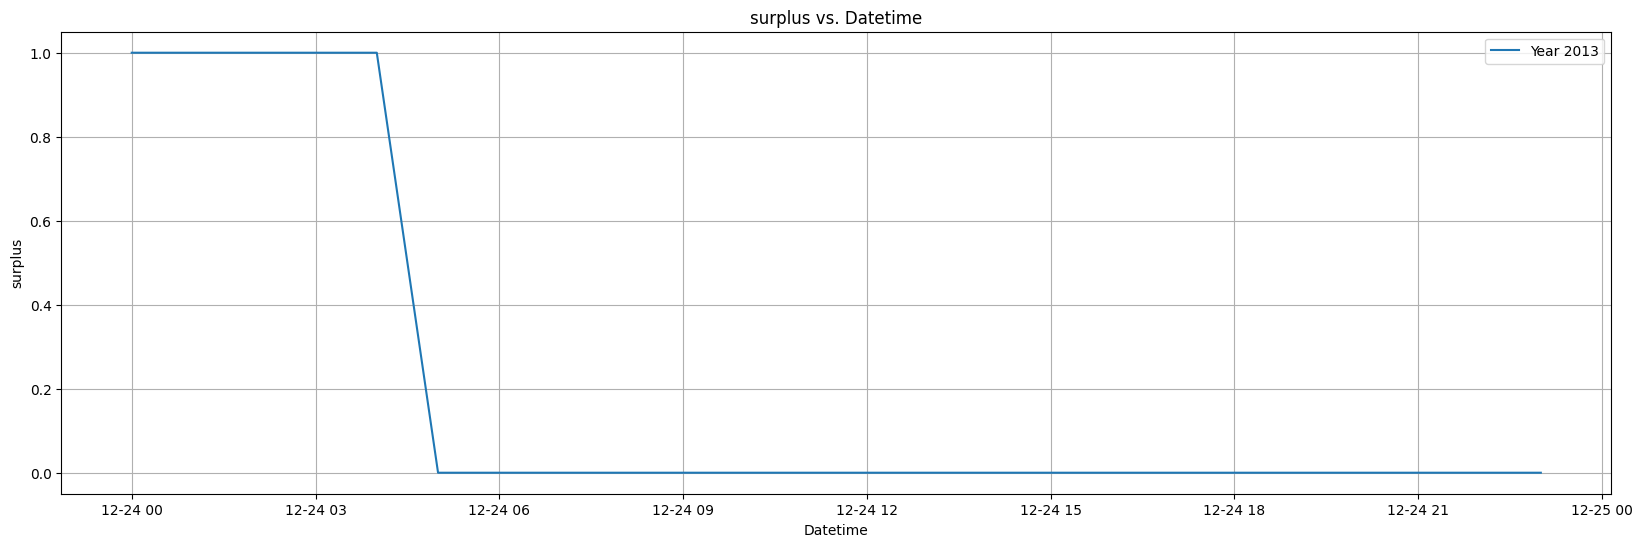

In [44]:
plot_data(X_train_weather_filled[(X_train_weather_filled.index.year == 2013) & (X_train_weather_filled.index.month == 12) & (X_train_weather_filled.index.day == 24)][['surplus']])



The above plot describes how the total enery surplus varies over the day in 24th of December 2013. From the plot we can say that there is an energy surplus between 12am-4am while there is not any surplus energy after 4am. This can be explained because 24th December is the day before Christmas and it is the winter time. Therefore, people are consuming more power in festive times for decorations and celebrations.